In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
from pathlib import Path
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [3]:
root = Path('./datasets')
zipn = 'house-prices-advanced-regression-techniques.zip'


with ZipFile(root/zipn, 'r') as f:
    f.extractall(root)

In [4]:
os.listdir(root)

['xtrain.csv',
 'test.csv',
 'data_description.txt',
 'house-prices-advanced-regression-techniques.zip',
 'train.csv',
 'xvalid.csv',
 'sample_submission.csv']

# Data analysis

In [5]:
train_df = pd.read_csv(root/'train.csv')
test_df = pd.read_csv(root/'test.csv')

pd.set_option('precision', 4)

In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.0000,1201.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1452.0000,1460.0000,...,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.000,1460.0000,1460.0000,1460.0000
mean,730.50,56.8973,70.0500,10516.8281,6.0993,5.5753,1971.2678,1984.8658,103.6853,443.6397,...,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,43.489,6.3219,2007.8158,180921.1959
std,421.61,42.3006,24.2848,9981.2649,1.3830,1.1128,30.2029,20.6454,181.0662,456.0981,...,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,496.123,2.7036,1.3281,79442.5029
min,1.00,20.0000,21.0000,1300.0000,1.0000,1.0000,1872.0000,1950.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,1.0000,2006.0000,34900.0000
25%,365.75,20.0000,59.0000,7553.5000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,5.0000,2007.0000,129975.0000
50%,730.50,50.0000,69.0000,9478.5000,6.0000,5.0000,1973.0000,1994.0000,0.0000,383.5000,...,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.000,6.0000,2008.0000,163000.0000
75%,1095.25,70.0000,80.0000,11601.5000,7.0000,6.0000,2000.0000,2004.0000,166.0000,712.2500,...,168.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.000,8.0000,2009.0000,214000.0000
max,1460.00,190.0000,313.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1600.0000,5644.0000,...,857.0000,547.0000,552.0000,508.0000,480.0000,738.0000,15500.000,12.0000,2010.0000,755000.0000


In [7]:
# explore missing value
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train_df.shape
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
vars_with_na = [var for var in train_df.columns if train_df[var].isnull().any()]

print(vars_with_na)
print(len(vars_with_na))

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
19


In [10]:
# density
train_df[vars_with_na].isnull().mean()

LotFrontage     0.1774
Alley           0.9377
MasVnrType      0.0055
MasVnrArea      0.0055
BsmtQual        0.0253
BsmtCond        0.0253
BsmtExposure    0.0260
BsmtFinType1    0.0253
BsmtFinType2    0.0260
Electrical      0.0007
FireplaceQu     0.4726
GarageType      0.0555
GarageYrBlt     0.0555
GarageFinish    0.0555
GarageQual      0.0555
GarageCond      0.0555
PoolQC          0.9952
Fence           0.8075
MiscFeature     0.9630
dtype: float64

In [11]:
# observe the median of the target where data is missing

def plot_target_on_missing(orig_df, var):
    df = orig_df.copy()
    df[var] = np.where(df[var].isnull(), 1, 0)
    df.groupby(var)['SalePrice'].median().plot.bar()
    plt.show()
    

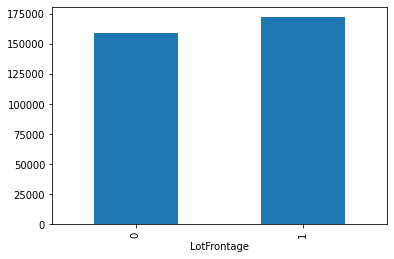

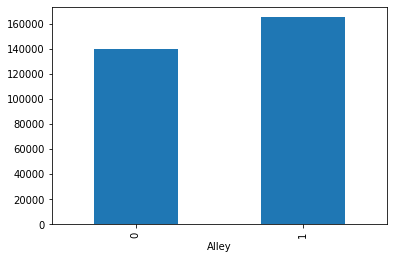

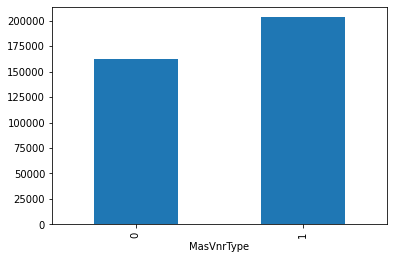

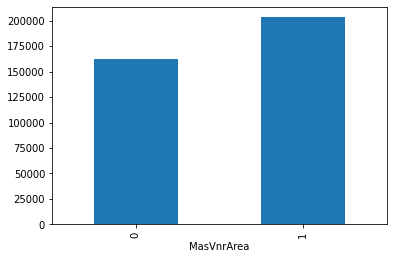

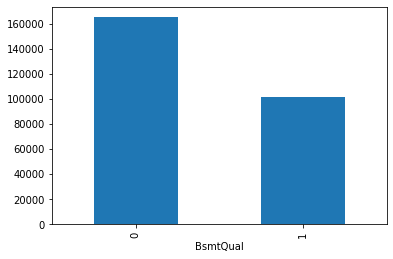

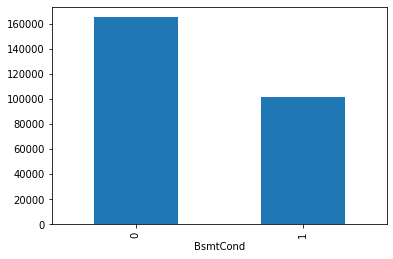

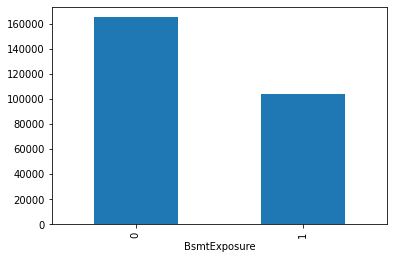

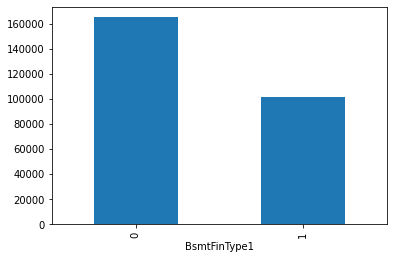

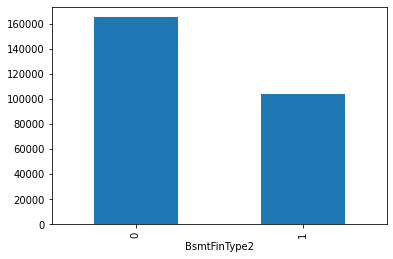

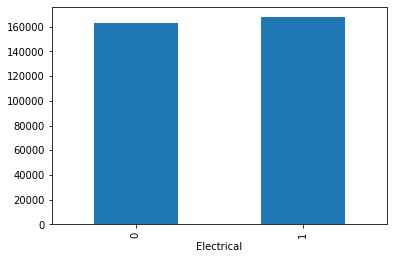

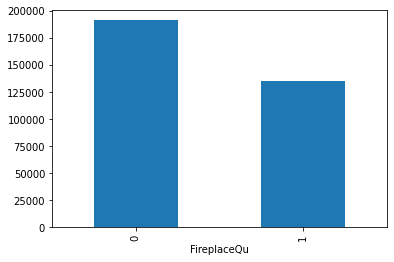

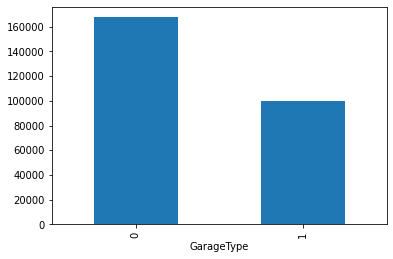

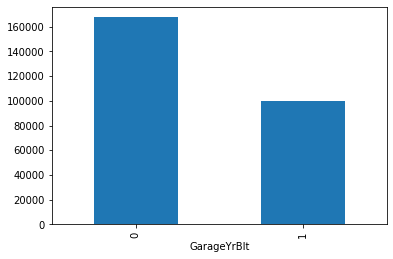

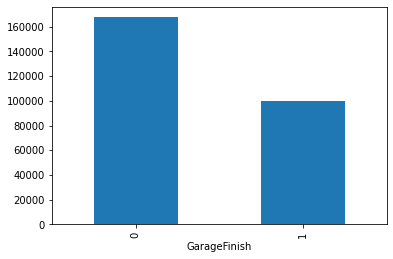

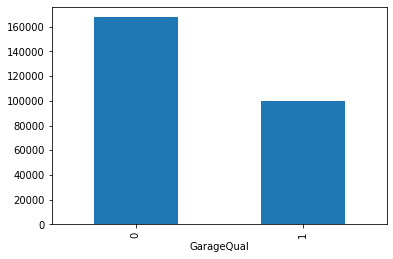

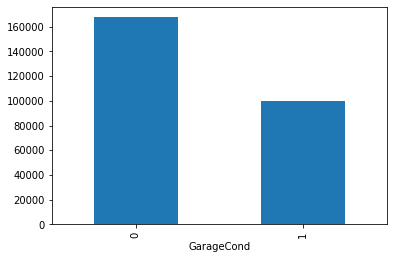

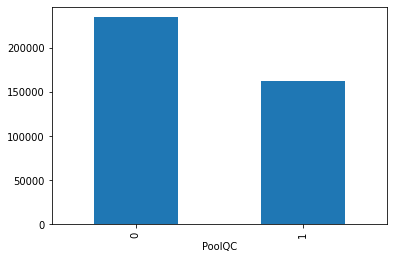

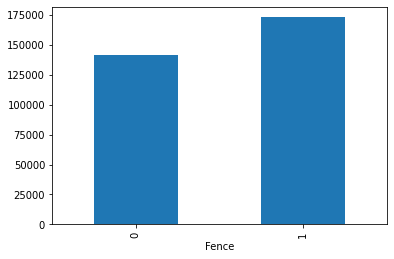

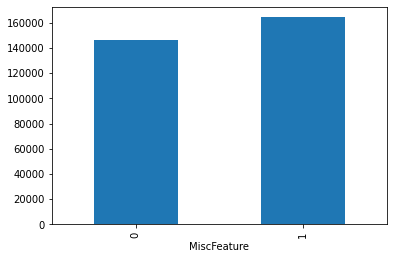

In [12]:
for var in vars_with_na:
    plot_target_on_missing(train_df, var)

In [13]:
## Filter numerical feature

num_vars = [var for var in train_df.columns if train_df[var].dtype != 'object' and var not in ['SalePrice']]
cat_vars = [var for var in train_df.columns if train_df[var].dtype == 'object' and var not in ['SalePrice']]

print(f'num vars: {num_vars}')
print(f'cat vars: {cat_vars}')

num vars: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
cat vars: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish'

In [14]:
train_df[num_vars].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008


In [15]:
for var in train_df.columns:
    if len(train_df[var].unique())/len(train_df) > 0.9:
        print(var)

Id


In [21]:
## temporal variable
temp_vars = [var for var in train_df.columns if 'Yr' in var or 'Year' in var]
print(temp_vars)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


<AxesSubplot:xlabel='YrSold'>

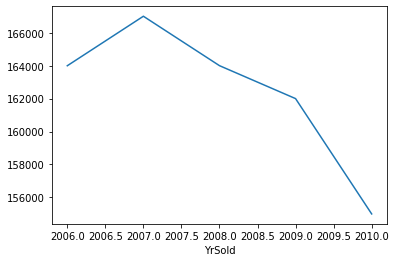

In [22]:
train_df.groupby('YrSold')['SalePrice'].median().plot()

In [23]:
def analyze_year_vars(orig_df, var):
    
    df = orig_df.copy()
    df['interval'] = df['YrSold'] - df[var]
    plt.scatter(df['interval'], df['SalePrice'])
    plt.title(var)
    plt.show()

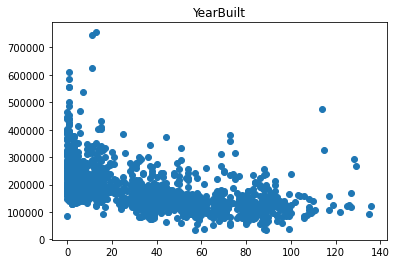

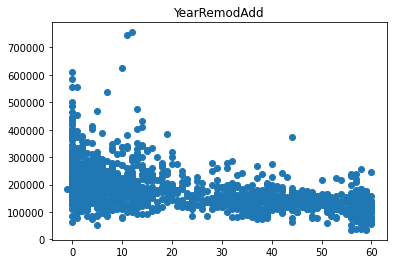

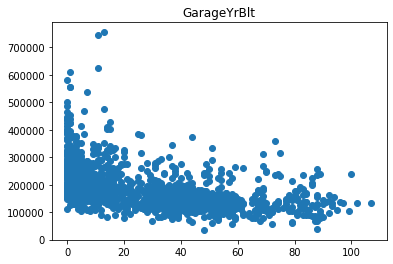

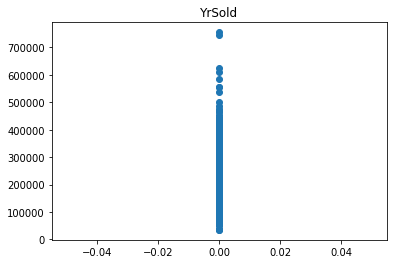

In [25]:
for var in temp_vars:
    analyze_year_vars(train_df, var)

In [26]:
## Discrete variable
dis_vars = [var for var in num_vars if len(train_df[var].unique()) < 20]
for var in temp_vars:
    if var in dis_vars:
        dis_vars.remove(var)

In [27]:
def analyze_discrete_vars(orig_df, var):
    df = orig_df.copy()
    df.groupby(var)['SalePrice'].median().plot.bar(x=var, y='SalePrice', rot=0)
    plt.title(var)
    plt.show()

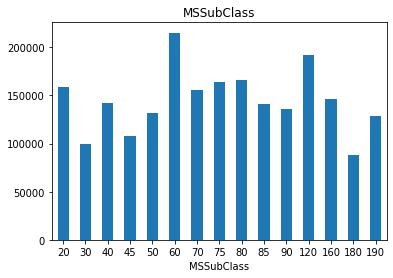

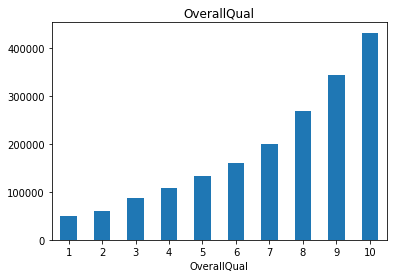

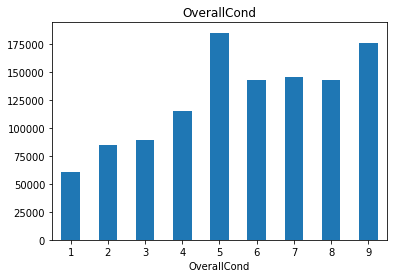

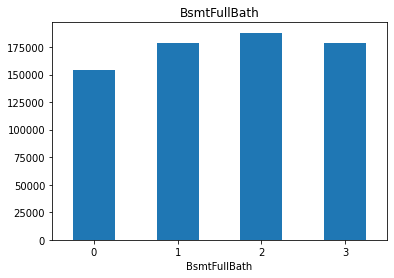

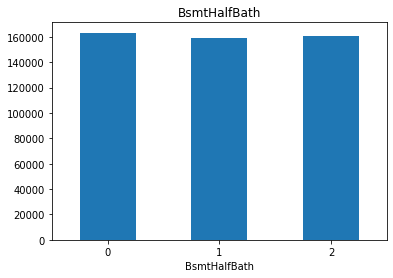

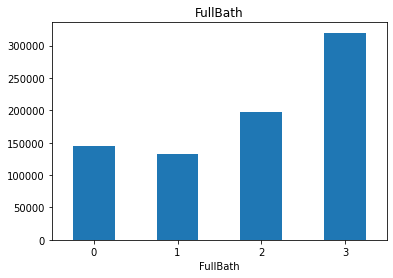

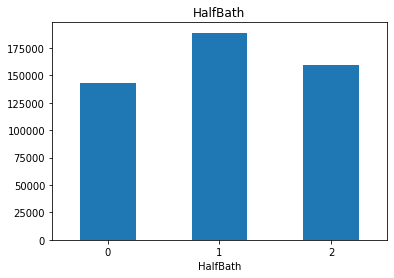

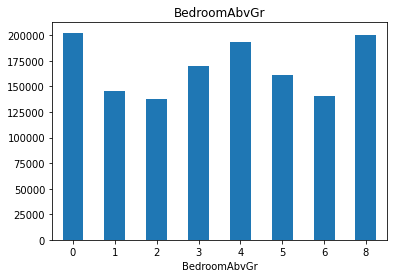

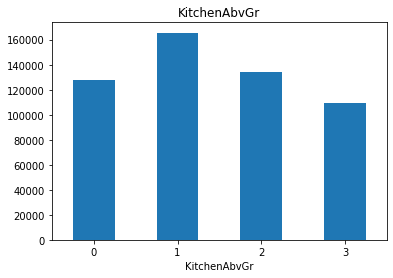

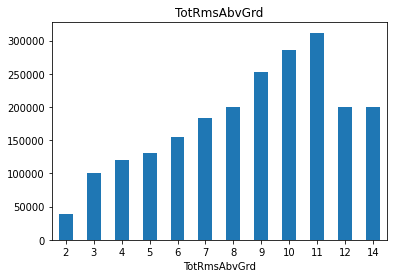

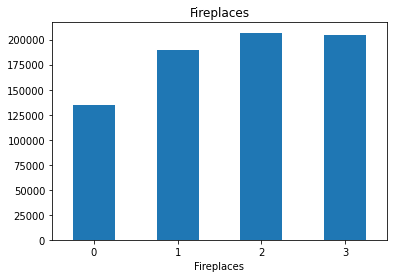

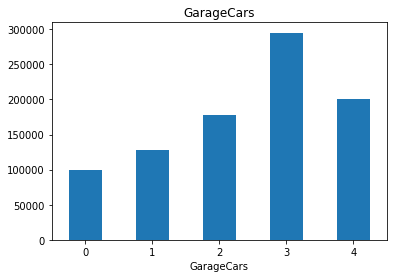

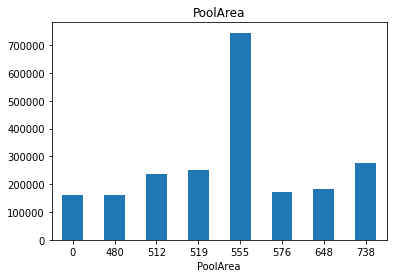

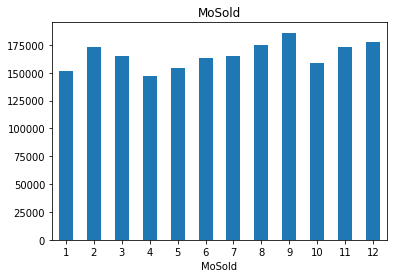

In [28]:
for var in dis_vars:
    analyze_discrete_vars(train_df, var)

In [29]:
cont_vars = [var for var in num_vars if var not in dis_vars + temp_vars+['Id','SalePrice']]

In [30]:
print(cont_vars)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']


In [31]:
def analyze_continuous_var(orig_df, var):
    df = orig_df.copy()
    plt.scatter(df[var], df['SalePrice'])
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.show()

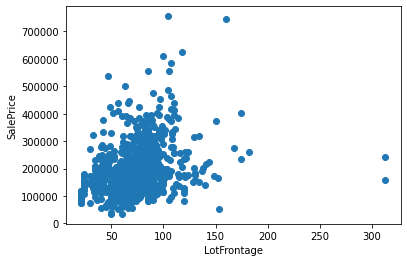

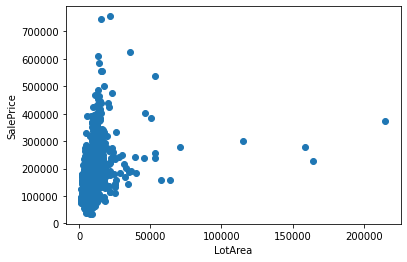

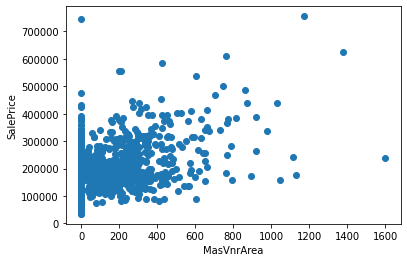

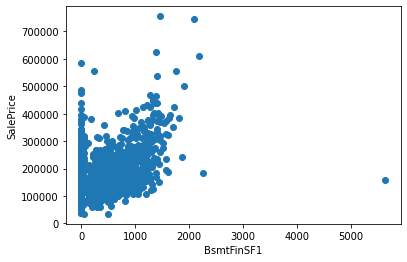

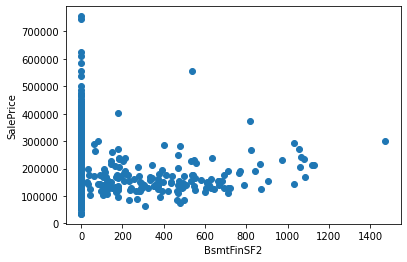

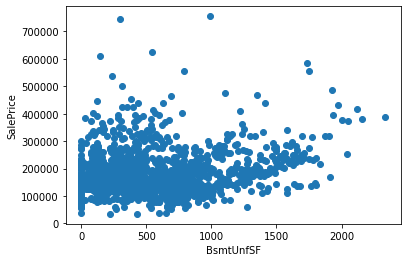

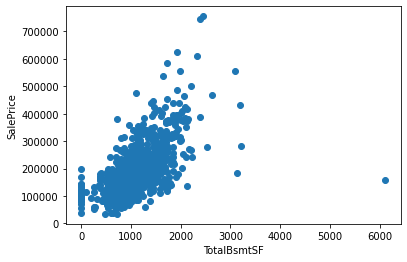

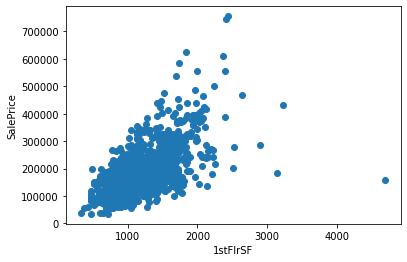

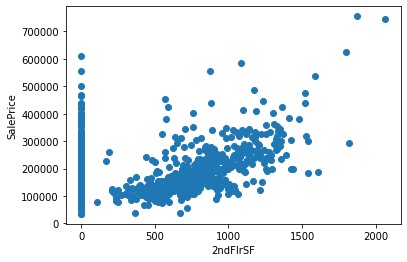

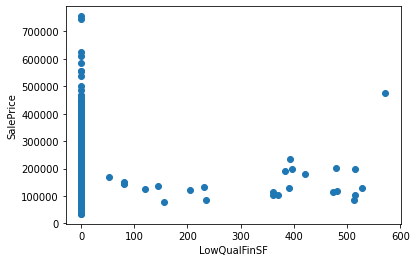

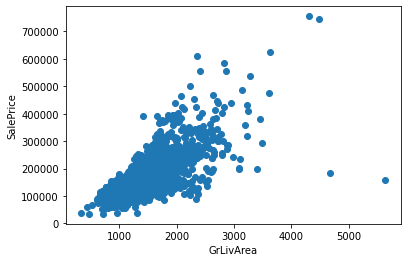

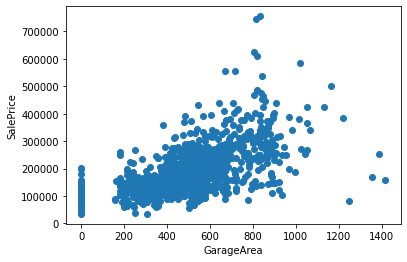

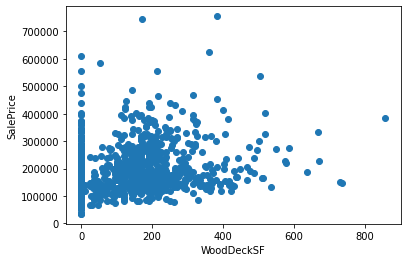

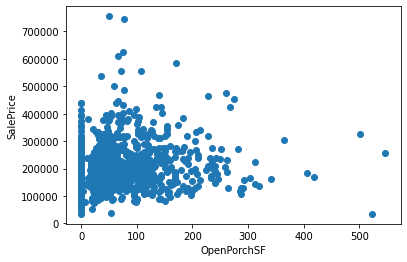

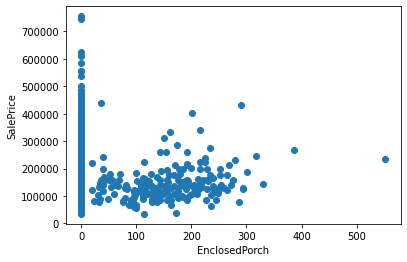

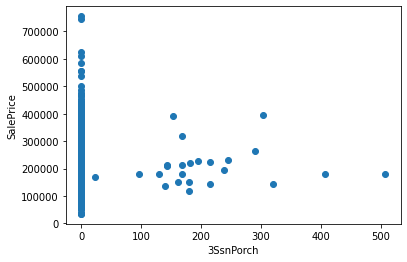

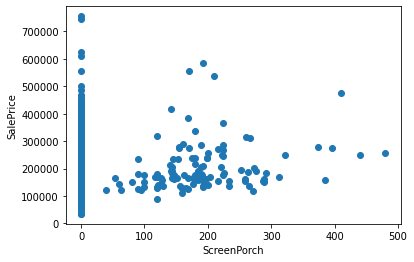

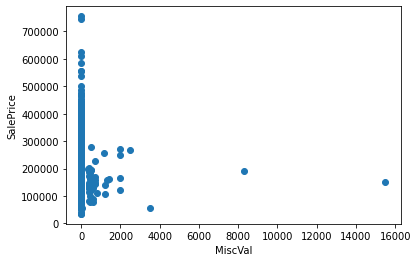

In [32]:
for var in cont_vars:
    analyze_continuous_var(train_df, var)

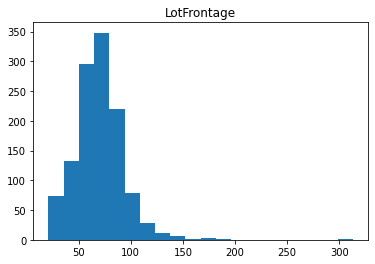

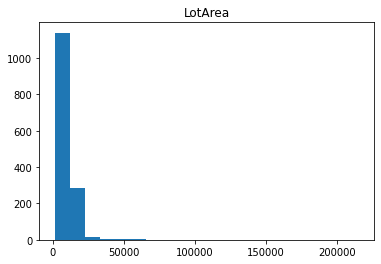

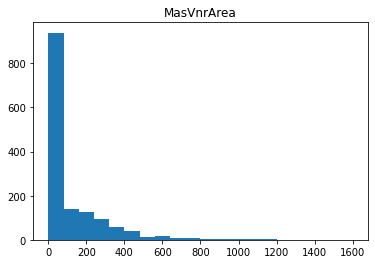

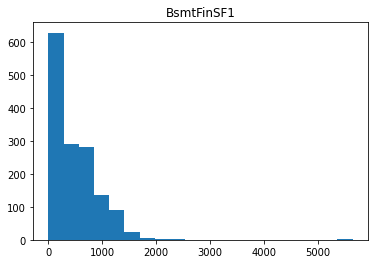

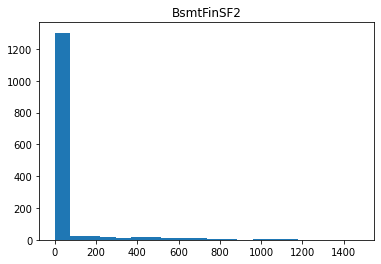

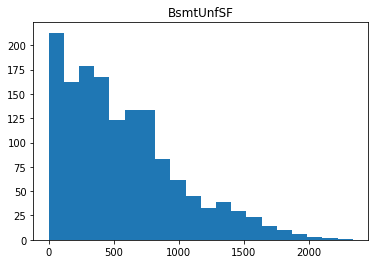

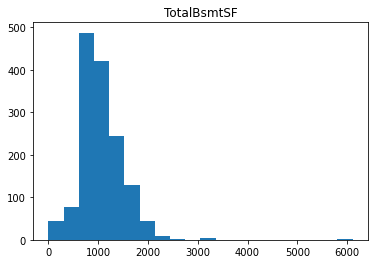

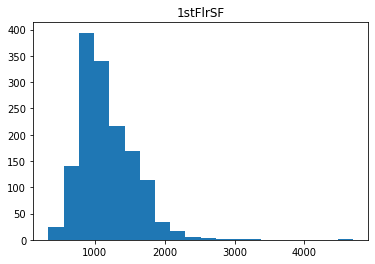

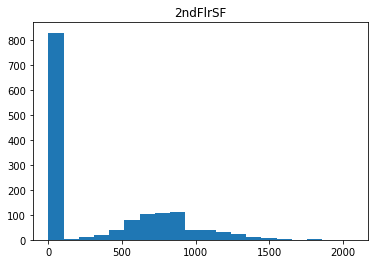

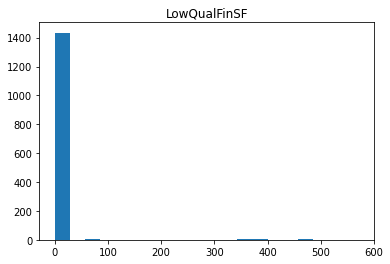

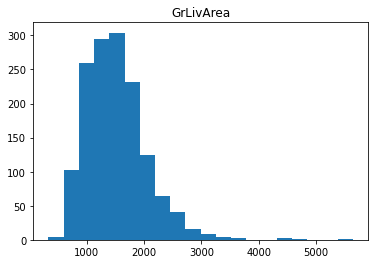

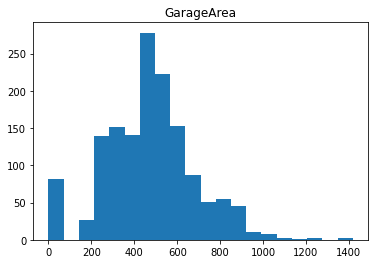

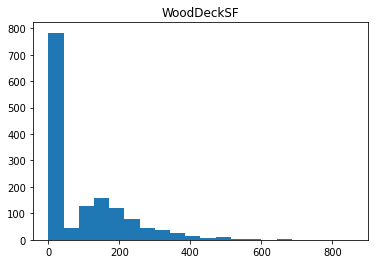

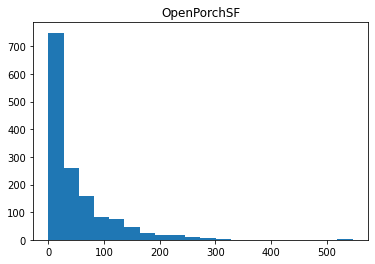

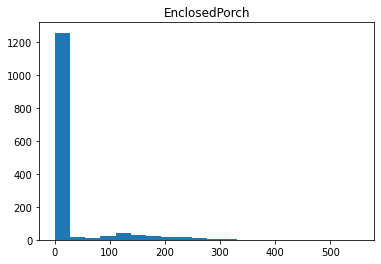

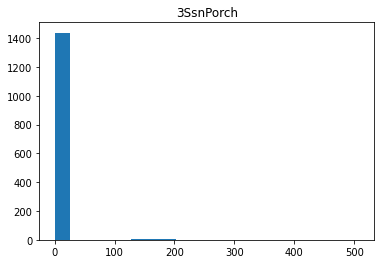

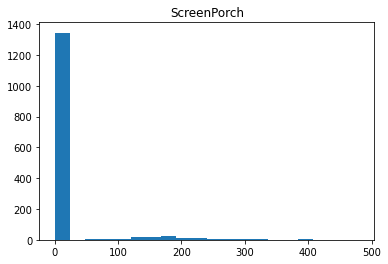

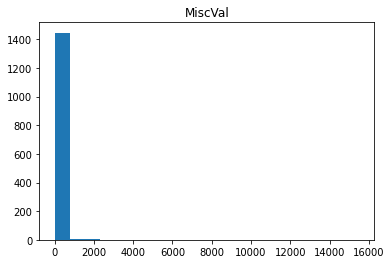

In [33]:
def analyze_distribution(orig_df, var):
    plt.hist(train_df[var], bins=20)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    analyze_distribution(train_df, var)

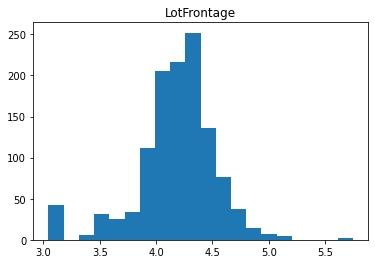

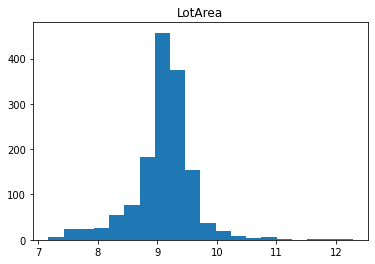

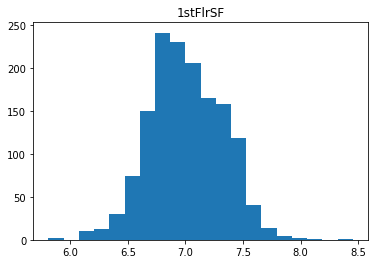

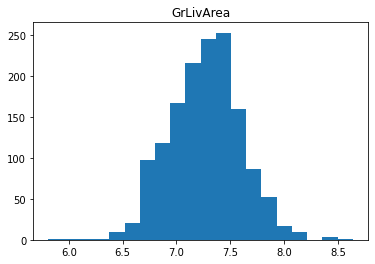

In [34]:
def analyze_distribution_with_transform(orig_df, var, method=None):
    df = orig_df.copy()
    if (df[var] <= 0).any():
        return
    
    if method is not None:    
        tf = PowerTransformer(method=method)
        df[var] = tf.fit_transform(np.array(df[var]).reshape(-1,1))
        plt.hist(df[var], bins=20)

        
    else:
        df[var] = np.log(df[var])
        plt.hist(df[var], bins=20)

    plt.title(var)
    plt.show()
        
for var in cont_vars:
    analyze_distribution_with_transform(train_df, var)

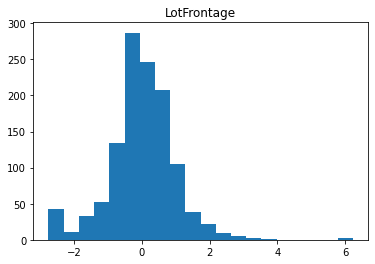

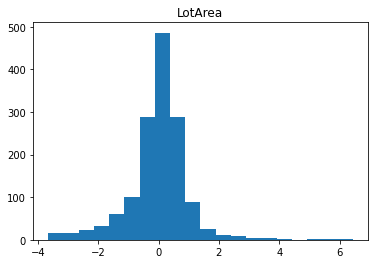

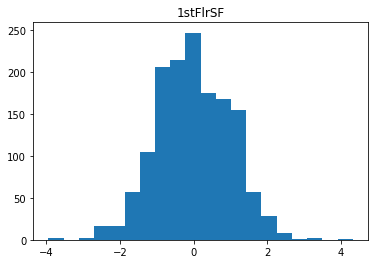

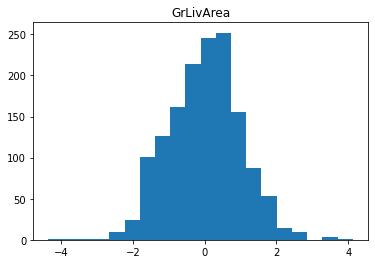

In [35]:
for var in cont_vars:
    analyze_distribution_with_transform(train_df, var, method='box-cox')

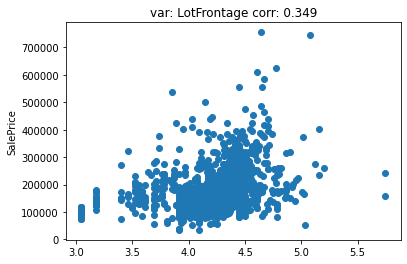

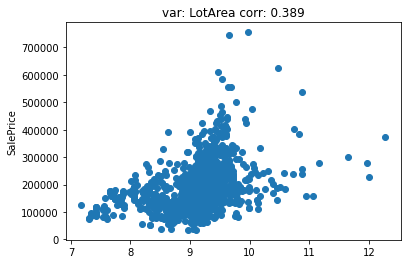

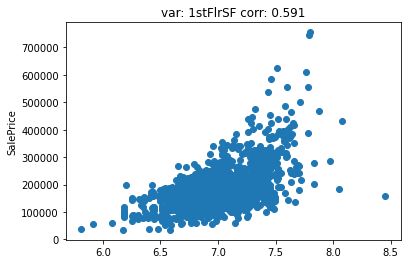

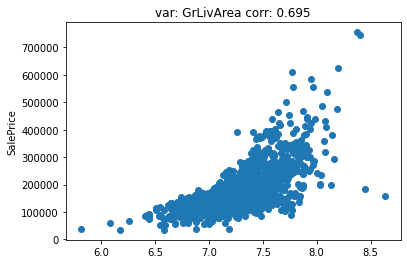

In [36]:
def analyze_cont_vars_with_transform(orig_df, var, method=None):
    df = orig_df.copy()
    if (df[var] <= 0).any():
        return
    
    if method is not None:    
        tf = PowerTransformer(method=method)
        df[var] = tf.fit_transform(np.array(df[var]).reshape(-1,1))
        
    else:
        df[var] = np.log(df[var])

    notnull_ind = df[var].notnull()
    plt.scatter(df[var], df['SalePrice'])
    plt.title(f'var: {var} corr: {np.corrcoef(df[var][notnull_ind], df["SalePrice"][notnull_ind])[0,1]:.3f}')
    plt.ylabel('SalePrice')
    plt.show()

for var in cont_vars:
    analyze_cont_vars_with_transform(train_df, var, method=None)

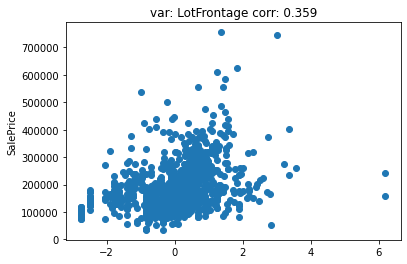

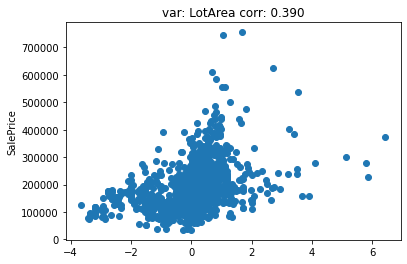

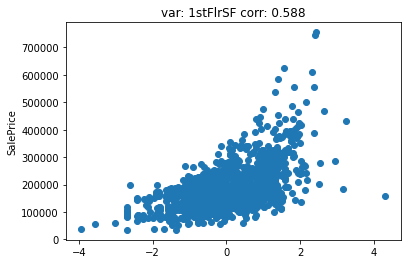

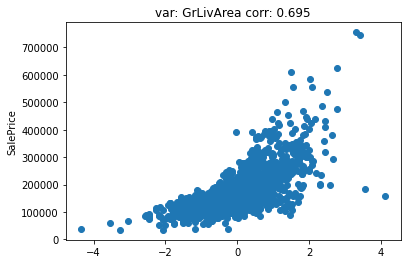

In [37]:
for var in cont_vars:
    analyze_cont_vars_with_transform(train_df, var, method='yeo-johnson')

In [38]:
def analyze_outlier(orig_df, var):
    df = orig_df.copy()
    isTf = False
    
    if not (df[var]<=0).any():
        isTf = True
        tf = PowerTransformer()
        df[var] = tf.fit_transform(np.array(df[var]).reshape(-1,1))

    plt.boxplot(df[var])
    plt.title(f'var: {var} transformed: {"Yes" if isTf else "No"}')
    plt.show()

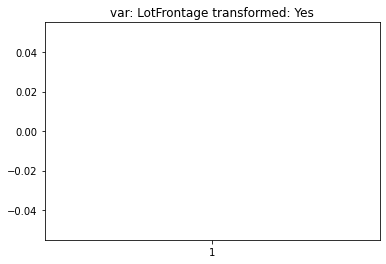

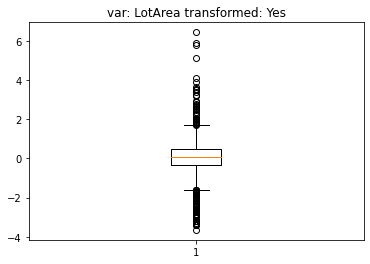

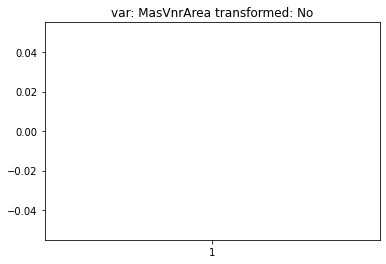

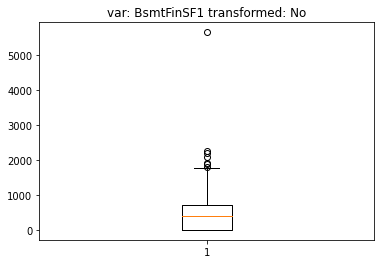

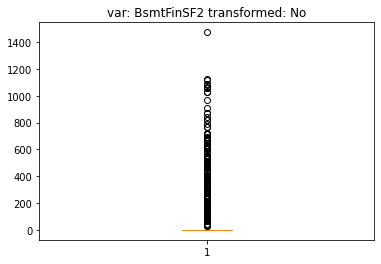

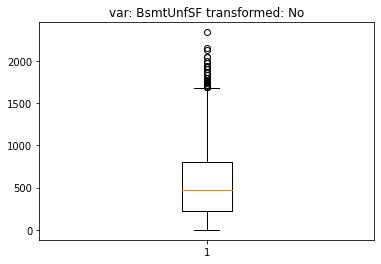

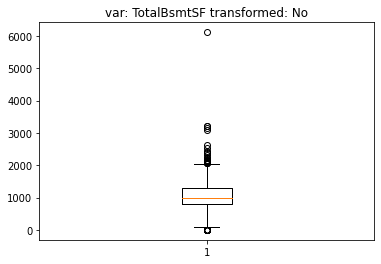

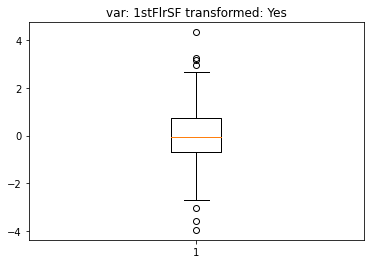

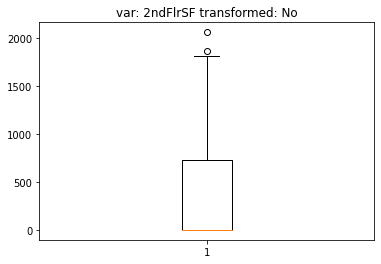

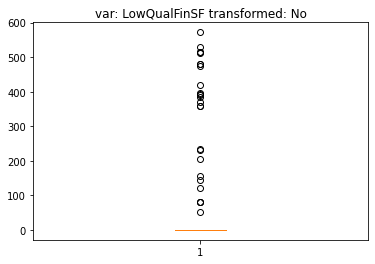

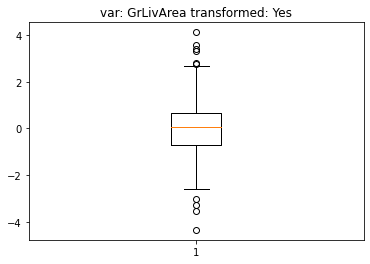

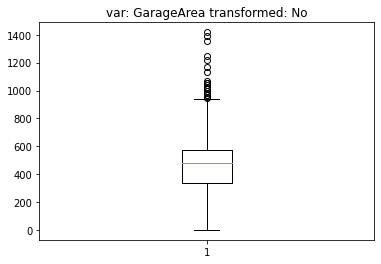

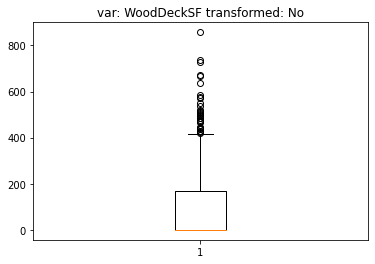

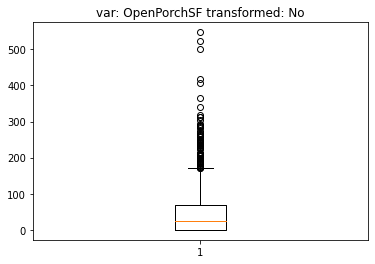

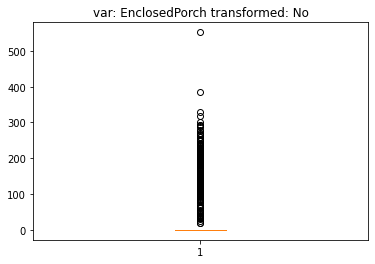

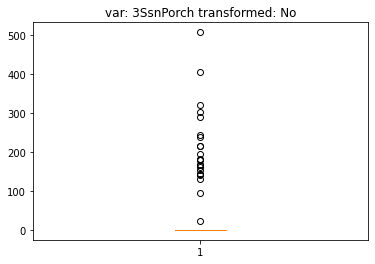

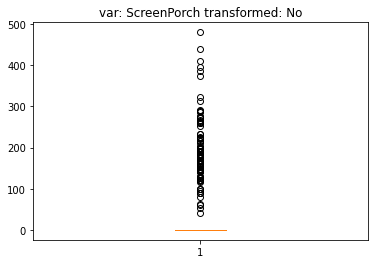

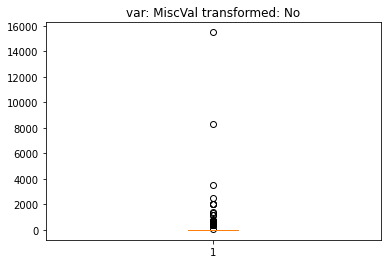

In [39]:
for var in cont_vars:
    analyze_outlier(train_df, var)

In [40]:
train_df[cat_vars].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [41]:
for var in cat_vars:
    print(var + ': '+ str(len(train_df[var].unique())))

MSZoning: 5
Street: 2
Alley: 3
LotShape: 4
LandContour: 4
Utilities: 2
LotConfig: 5
LandSlope: 3
Neighborhood: 25
Condition1: 9
Condition2: 8
BldgType: 5
HouseStyle: 8
RoofStyle: 6
RoofMatl: 8
Exterior1st: 15
Exterior2nd: 16
MasVnrType: 5
ExterQual: 4
ExterCond: 5
Foundation: 6
BsmtQual: 5
BsmtCond: 5
BsmtExposure: 5
BsmtFinType1: 7
BsmtFinType2: 7
Heating: 6
HeatingQC: 5
CentralAir: 2
Electrical: 6
KitchenQual: 4
Functional: 7
FireplaceQu: 6
GarageType: 7
GarageFinish: 4
GarageQual: 6
GarageCond: 6
PavedDrive: 3
PoolQC: 4
Fence: 5
MiscFeature: 5
SaleType: 9
SaleCondition: 6


In [42]:
def analyze_rare_labels(orig_df, var, plot=True, perc=0.01):
    df = orig_df.copy()
    series = df.groupby(var)[var].count()/len(df)
    
    if plot:
        plt.bar(series.index, series)
        plt.title(var)
        plt.show()
    else:
        print(series[series < perc])

In [43]:
for var in cat_vars:
    analyze_rare_labels(train_df, var, plot=False)

MSZoning
C (all)    0.0068
Name: MSZoning, dtype: float64
Street
Grvl    0.0041
Name: Street, dtype: float64
Series([], Name: Alley, dtype: float64)
LotShape
IR3    0.0068
Name: LotShape, dtype: float64
Series([], Name: LandContour, dtype: float64)
Utilities
NoSeWa    0.0007
Name: Utilities, dtype: float64
LotConfig
FR3    0.0027
Name: LotConfig, dtype: float64
LandSlope
Sev    0.0089
Name: LandSlope, dtype: float64
Neighborhood
Blueste    0.0014
NPkVill    0.0062
Veenker    0.0075
Name: Neighborhood, dtype: float64
Condition1
PosA    0.0055
RRAe    0.0075
RRNe    0.0014
RRNn    0.0034
Name: Condition1, dtype: float64
Condition2
Artery    0.0014
Feedr     0.0041
PosA      0.0007
PosN      0.0014
RRAe      0.0007
RRAn      0.0007
RRNn      0.0014
Name: Condition2, dtype: float64
Series([], Name: BldgType, dtype: float64)
HouseStyle
1.5Unf    0.0096
2.5Fin    0.0055
2.5Unf    0.0075
Name: HouseStyle, dtype: float64
RoofStyle
Flat       0.0089
Gambrel    0.0075
Mansard    0.0048
Shed     

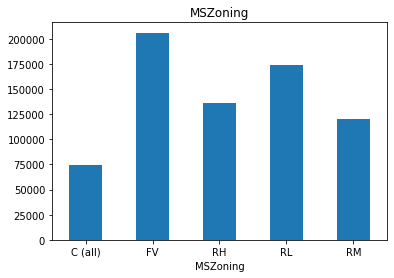

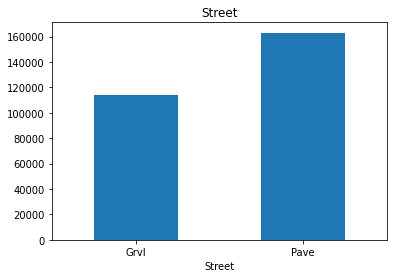

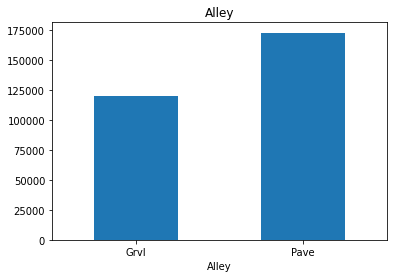

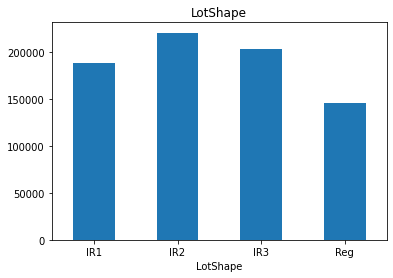

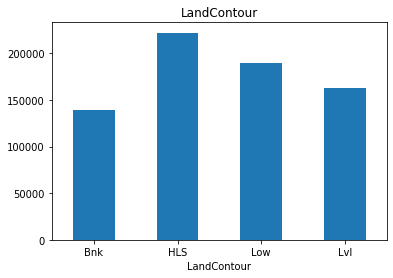

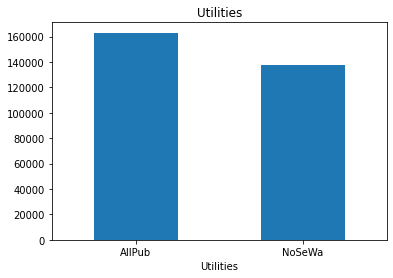

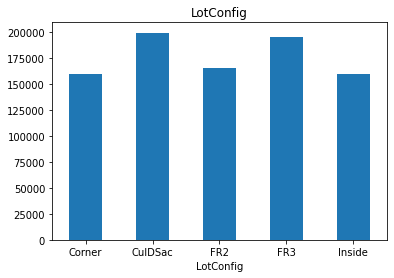

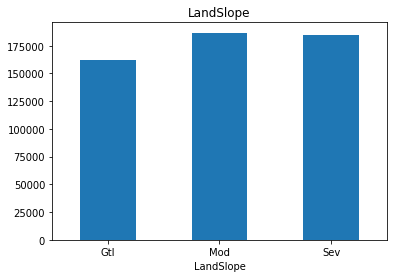

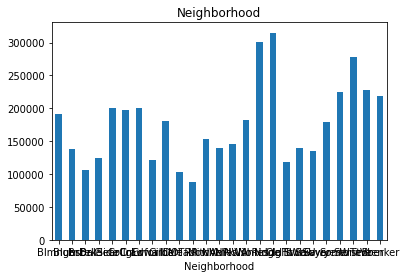

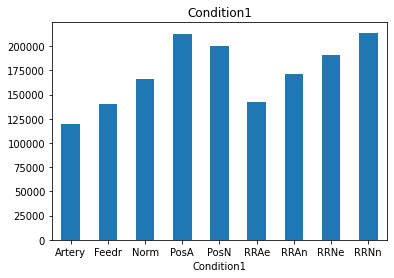

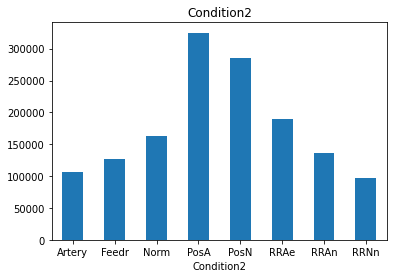

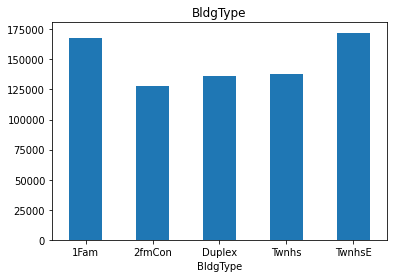

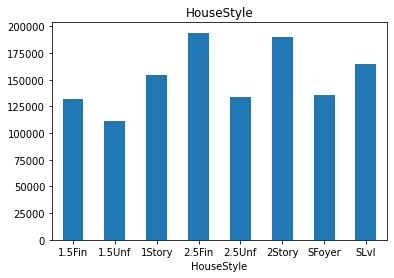

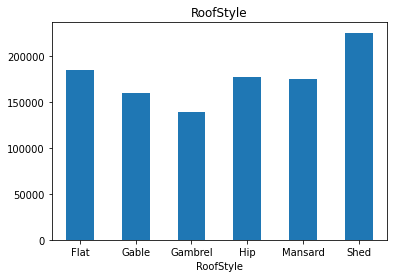

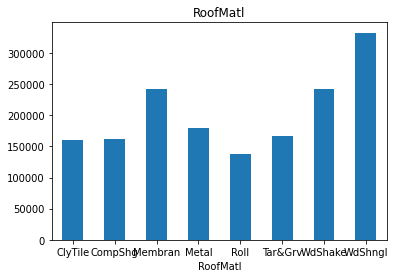

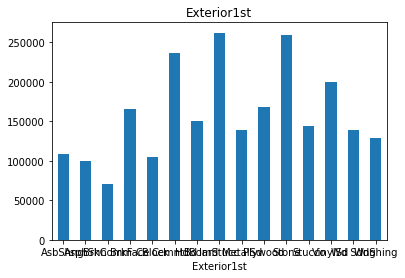

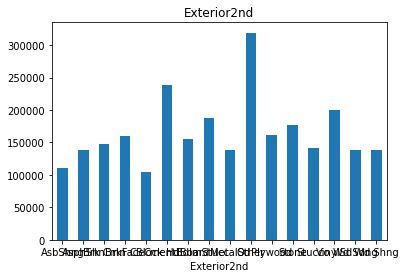

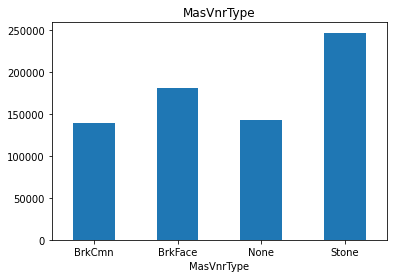

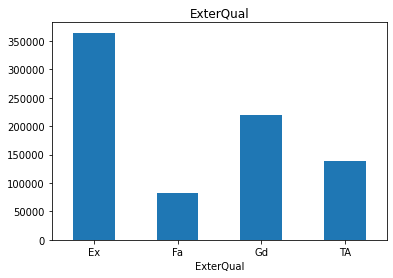

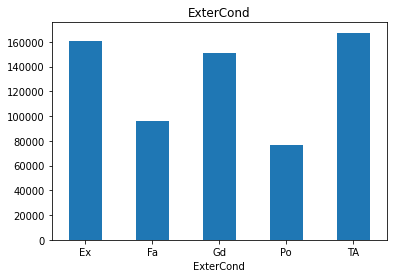

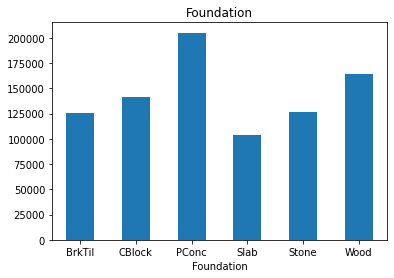

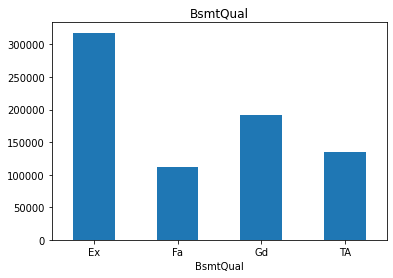

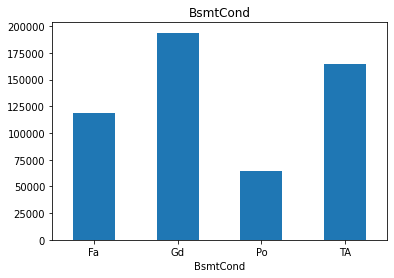

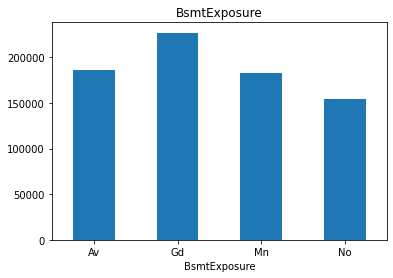

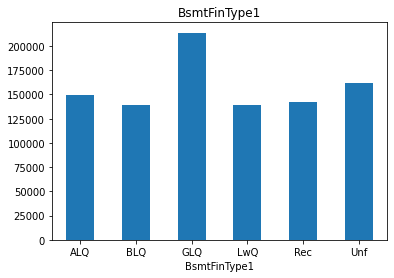

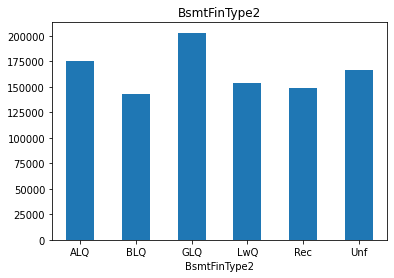

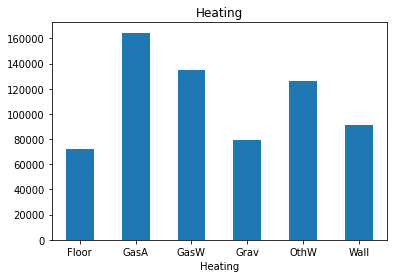

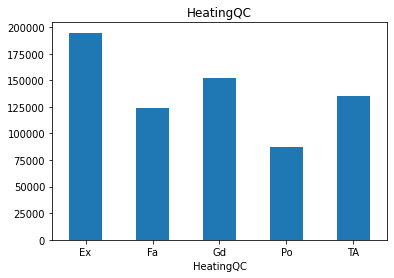

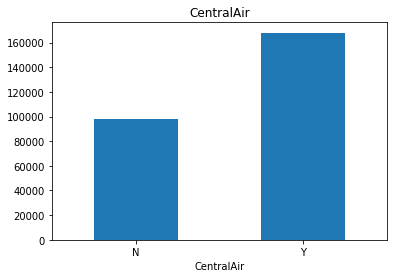

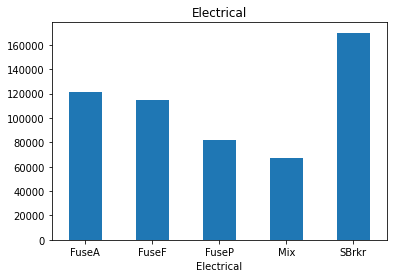

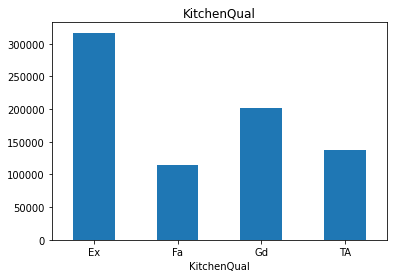

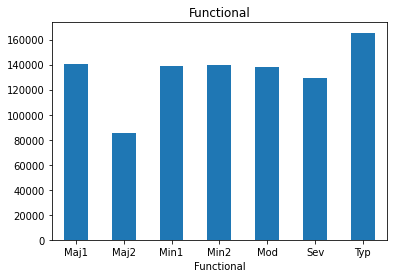

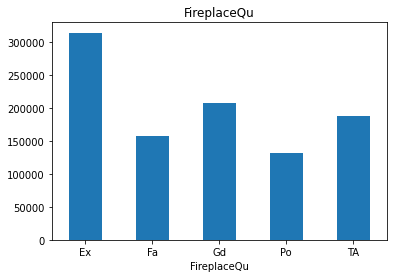

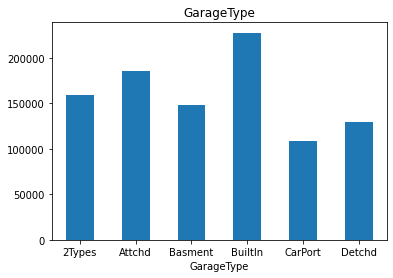

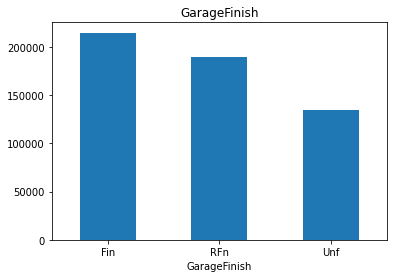

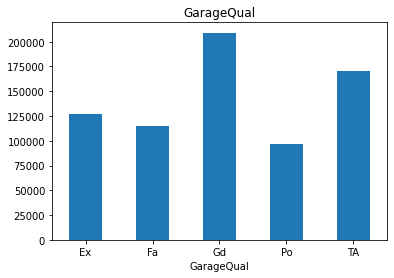

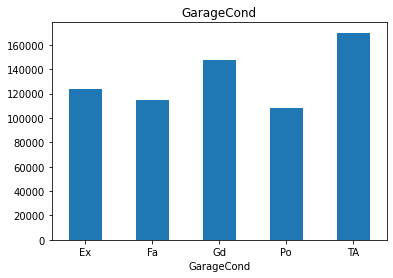

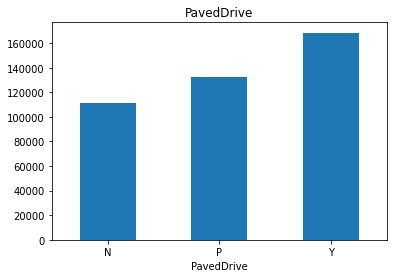

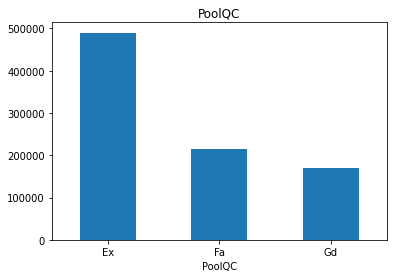

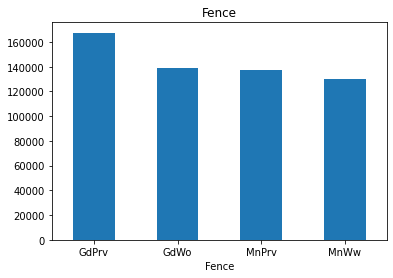

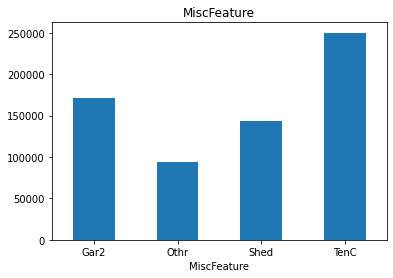

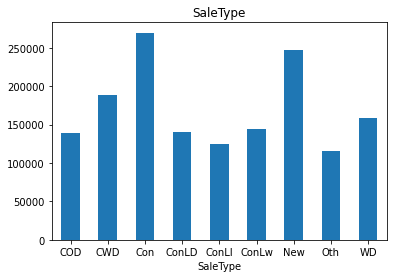

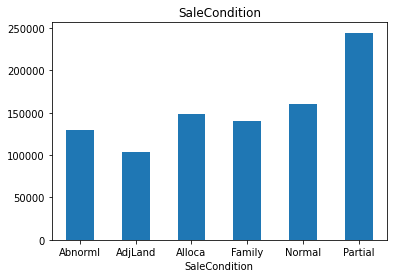

In [44]:
for var in cat_vars:
    analyze_discrete_vars(train_df, var)

# Feature engineering

## Fill missing values

In [45]:
# fill missing value with mean
np.random.seed(42)
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(columns=['SalePrice']), train_df['SalePrice'], 
    test_size=0.15)

In [46]:
print(x_train.shape)
print(x_valid.shape)

(1241, 80)
(219, 80)


In [47]:
cat_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
num_imputer = SimpleImputer(strategy="median", add_indicator=True)

cat_imputer.fit(x_train[cat_vars])
num_imputer.fit(x_train[num_vars])

def fill_missing_values(orig_df):
    df = orig_df.copy()
    

    df[cat_vars] = cat_imputer.transform(df[cat_vars])

    num_impute_w_indicator = num_imputer.transform(df[num_vars])

    # find increaseing feature of num indicator
    num_indicator = num_impute_w_indicator.shape[1] - df[num_vars].shape[1] 
    df[num_vars] = num_impute_w_indicator[:, :-num_indicator]

    for i in range(num_indicator):
        df[str(i)+"_na"] = num_impute_w_indicator[:, -i-1]
        
    return df, cat_imputer, num_imputer

In [48]:
x_train_filled, cat_imputer, num_imputer = fill_missing_values(x_train)
x_valid_filled, _, _ = fill_missing_values(x_valid)

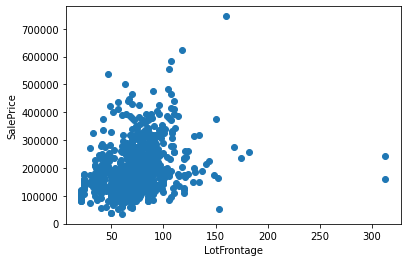

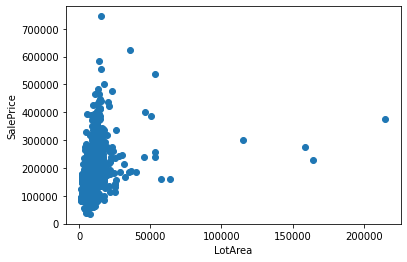

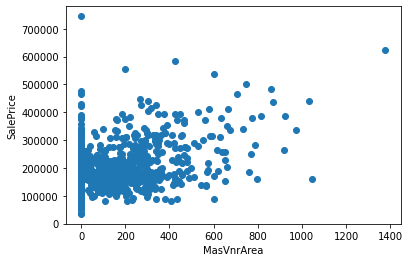

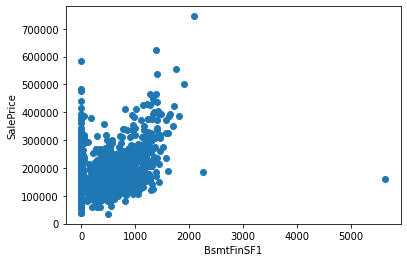

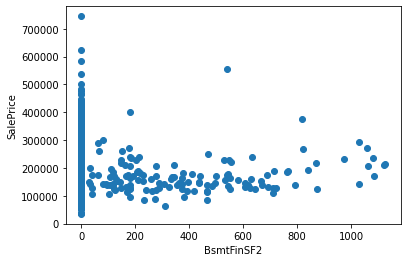

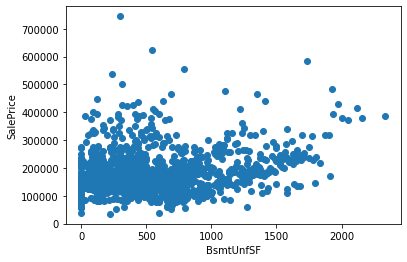

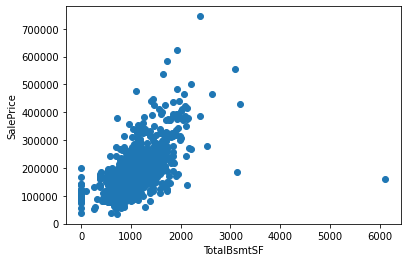

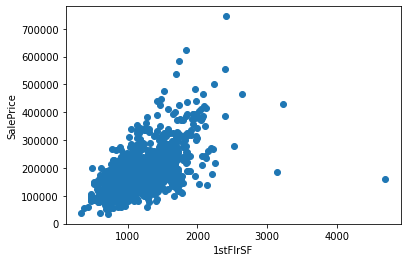

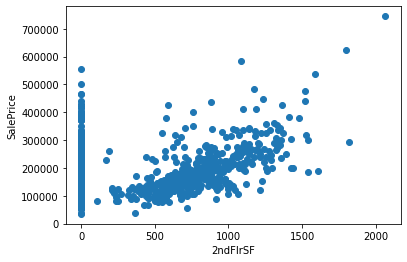

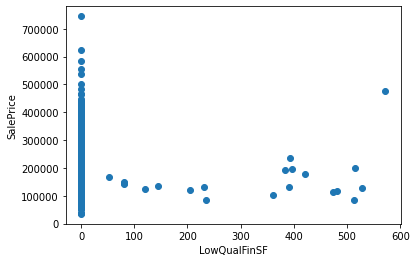

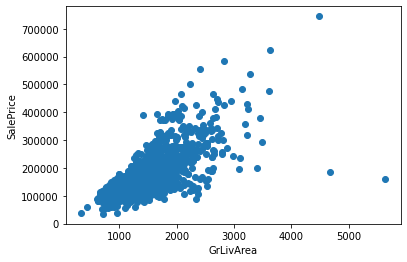

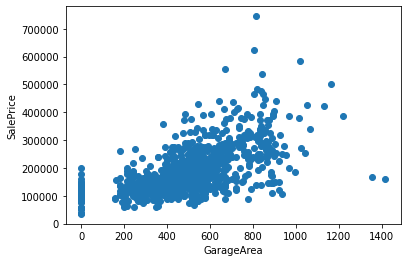

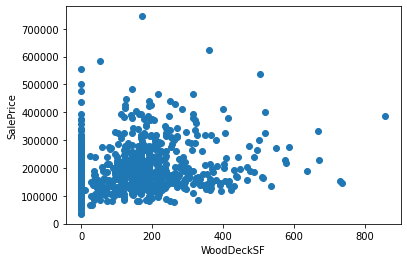

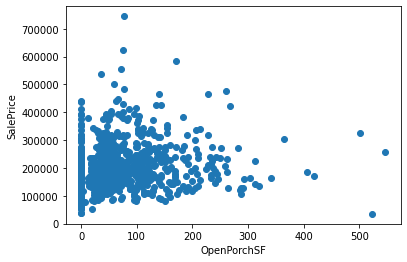

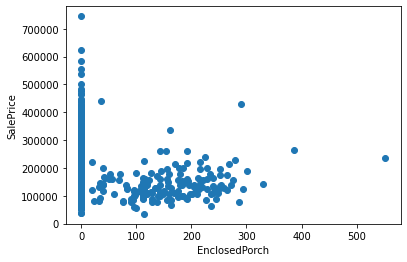

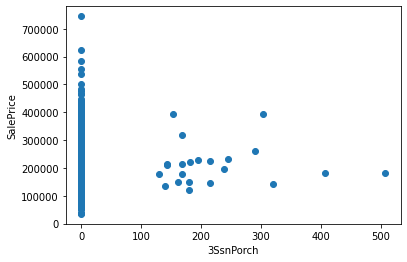

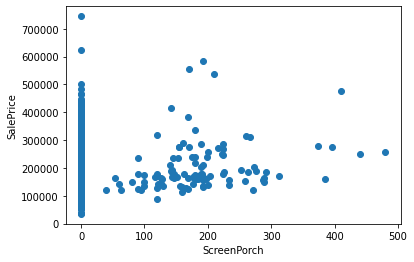

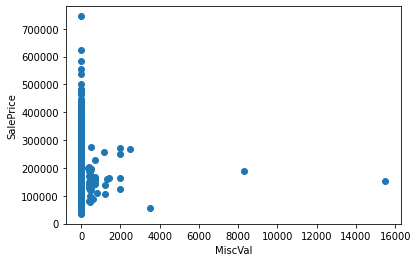

In [49]:
temp = x_train_filled.copy()
temp['SalePrice']=y_train
for var in cont_vars:
    analyze_continuous_var(temp, var)

## Add elapsed year

In [333]:
def add_elapsedyear(orig_df, var):
    df = orig_df.copy()
    df[var] = df['YrSold'] - df[var]
    return df

x_train_add_elapse = add_elapsedyear(x_train_filled, 'YearRemodAdd')
x_valid_add_elapse = add_elapsedyear(x_valid_filled, 'YearRemodAdd')

## Log transform 

In [334]:
tf = PowerTransformer()
x_train_tf = x_train_add_elapse.copy()
x_valid_tf = x_valid_add_elapse.copy()

tf.fit(x_train_tf[cont_vars])
x_train_tf[cont_vars] = tf.transform(x_train_tf[cont_vars])
x_valid_tf[cont_vars] = tf.transform(x_valid_tf[cont_vars])

In [335]:
x_valid_tf.isnull().any().any()

False

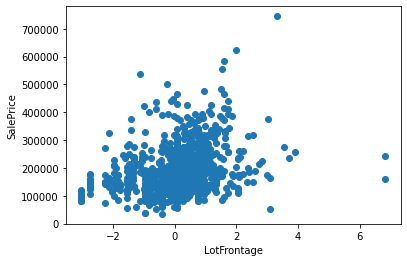

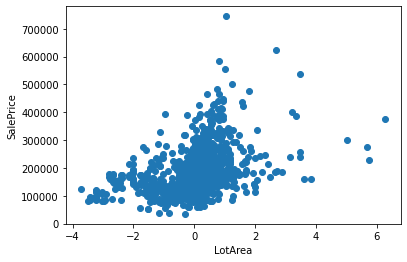

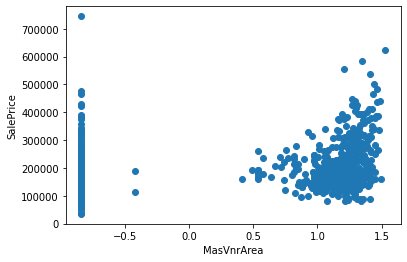

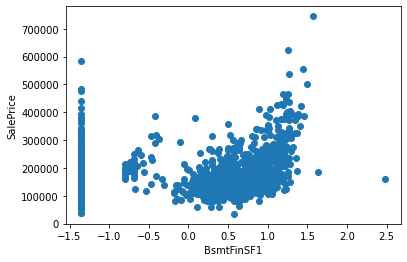

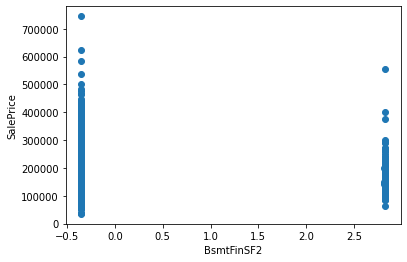

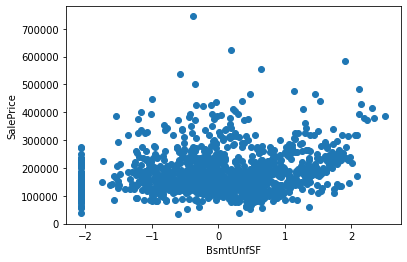

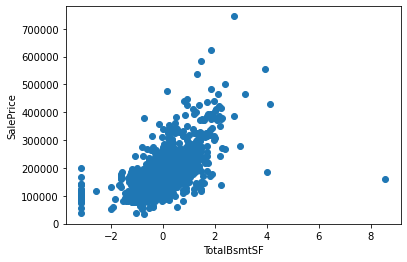

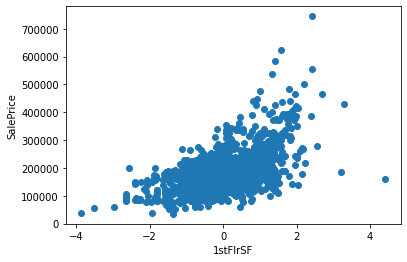

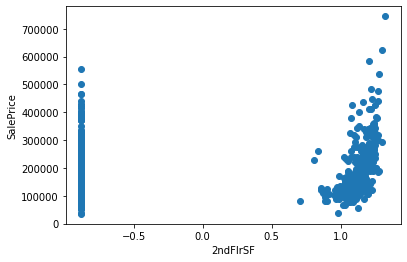

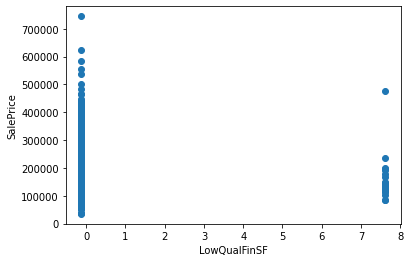

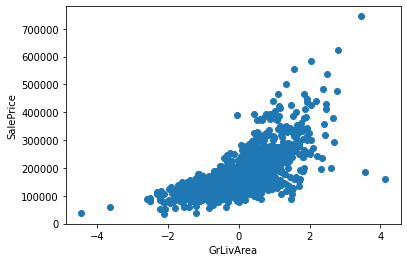

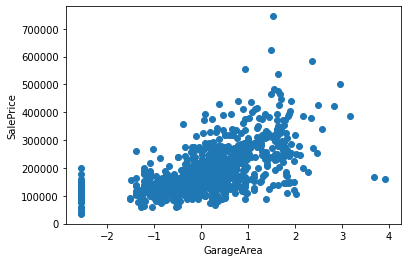

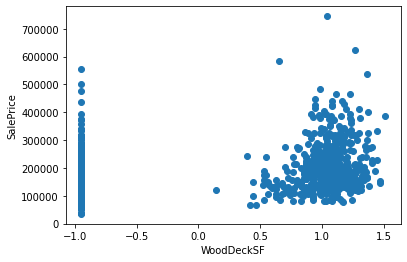

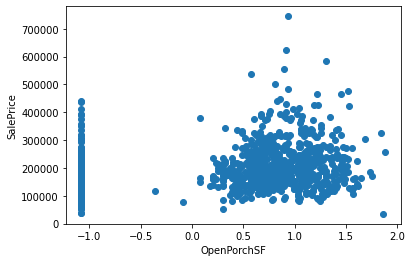

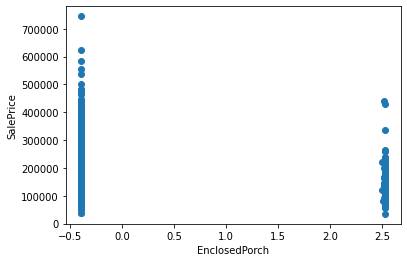

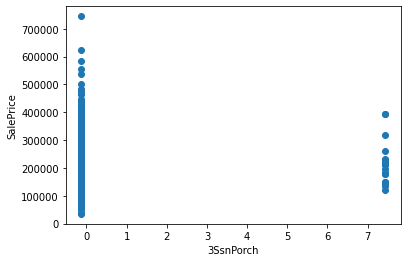

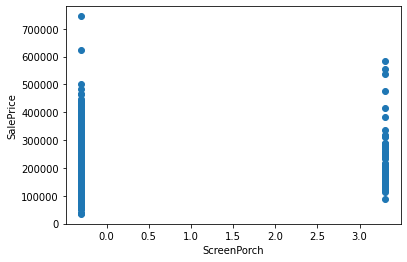

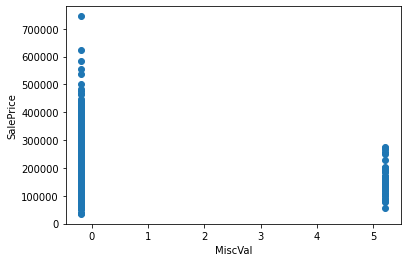

In [336]:
temp = x_train_tf.copy()
temp['SalePrice']=y_train
for var in cont_vars:
    analyze_continuous_var(temp, var)

## Remove rare labels

In [420]:
def identify_rare_labels(orig_df, var):
    df = orig_df.copy()
    new_df = df.groupby(var)[var].count()/len(df)
    return new_df[new_df < 0.01].dropna().index

def remove_rare_label(orig_df, orig_df_valid=None, rare_labels=None):
    df = orig_df.copy()
    
    if rare_labels is not None:
        for var in cat_vars:
            rare_label = rare_labels[var]
            df[var] = np.where(df[var].isin(rare_label), 'rare', df[var])
            return df
    else:
        df_valid = orig_df_valid.copy()

        for var in cat_vars:
            rare_label = identify_rare_labels(df, var)
            rare_label_dic[var] = rare_label
            df[var] = np.where(df[var].isin(rare_label), 'rare', df[var])
            df_valid[var] = np.where(df_valid[var].isin(rare_label), 'rare', df_valid[var])

        return df, df_valid

rare_label_dic = {}
x_train_fill_rmrare, x_valid_fill_rmrare = remove_rare_label(x_train_tf, x_valid_tf)

## Label encoding

In [444]:
def label_encoding_w_order(orig_df_train, var, orig_df_valid=None, word_index_dic=None):

    df = orig_df_train.copy()
        
    if word_index_dic is not None:
        word_index = word_index_dic[var]
        df[var] = df[var].map(lambda x : word_index[x] if x in word_index else word_index['unk'])
        return df[var]
        
    else:
    
        df_valid = orig_df_valid.copy()

        label_train = list(df.groupby(var)['SalePrice'].median().sort_values().index)
        label_valid = list(df_valid[var].unique())
        label_notin = [lab for lab in label_valid if lab not in label_train]

        if len(label_notin) > 0:
            label = label_train + label_notin
        else:
            label = label_train
            
        for add_label in ['Missing', 'unk']:
            if add_label not in label:
                label = [add_label] + label

        word_index = {k:i for i, k in enumerate(label)}
        df[var] = df[var].map(word_index)
        df_valid[var] = df_valid[var].map(word_index)

        return df[var], df_valid[var], word_index

x_train_prep = x_train_fill_rmrare.copy()
x_valid_prep = x_valid_fill_rmrare.copy()

temp = x_train_fill_rmrare.copy()
temp['SalePrice'] = y_train
word_index_dic = {}
    
for var in cat_vars:
    x_train_prep[var], x_valid_prep[var], word_index_dic[var] = label_encoding_w_order(temp, var, x_valid_fill_rmrare)

## Label encoding w/o ordering
label_encoder = OrdinalEncoder()
label_encoder.fit(x_train_fill_rmrare[cat_vars])

x_train_prep = x_train_fill_rmrare.copy()
x_train_prep[cat_vars] = label_encoder.transform(x_train_fill_rmrare[cat_vars])

x_train_prep[cat_vars].head()

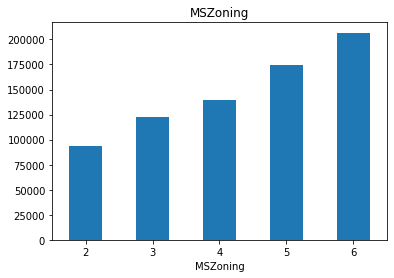

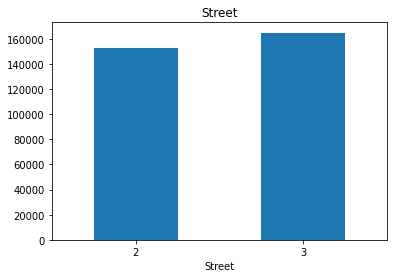

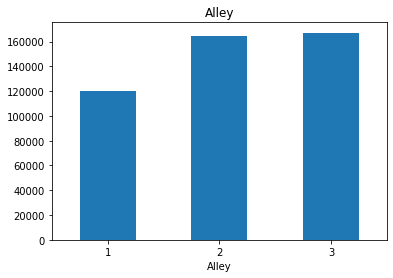

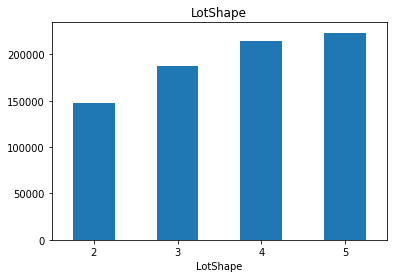

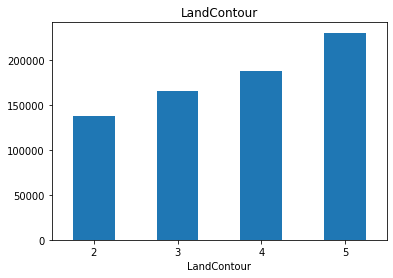

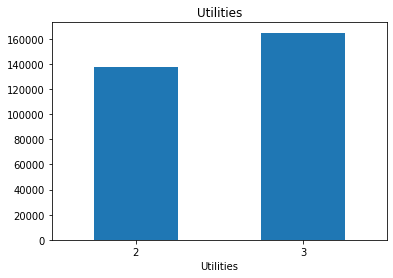

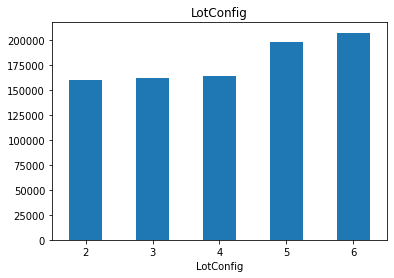

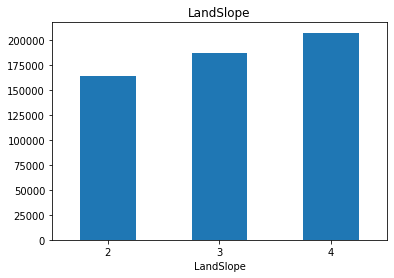

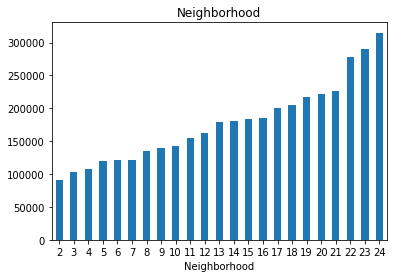

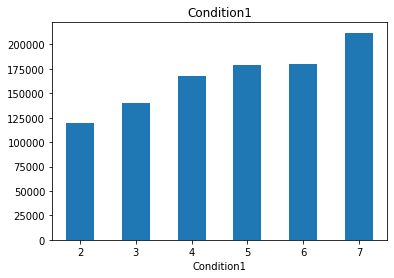

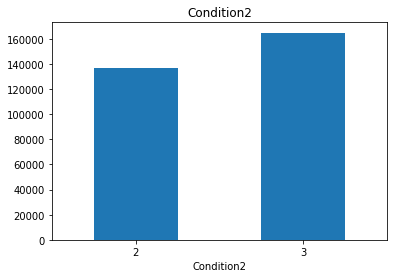

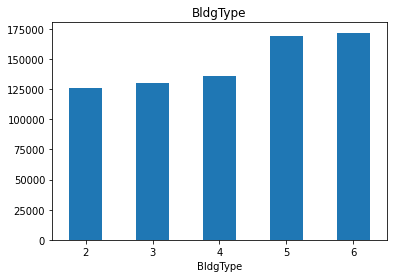

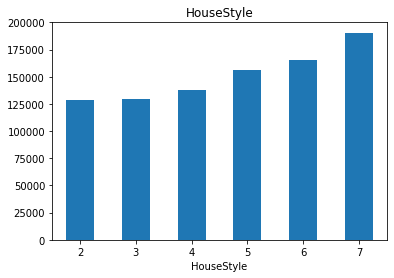

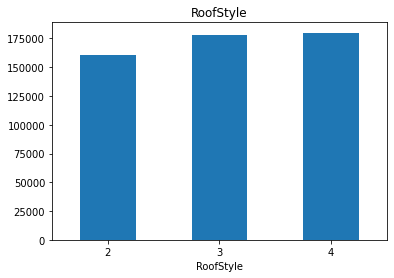

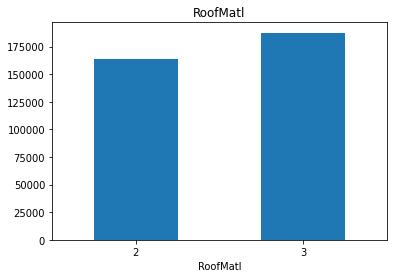

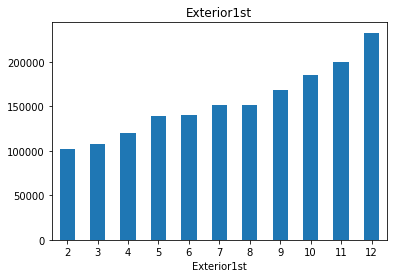

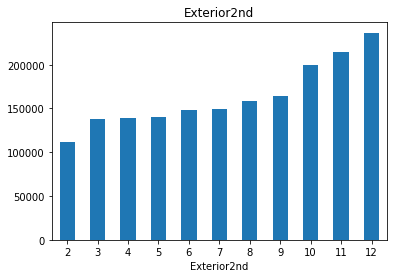

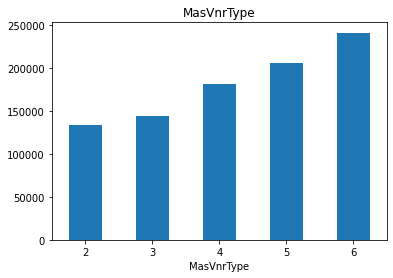

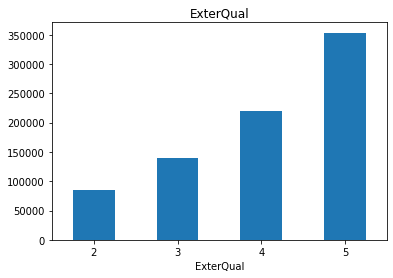

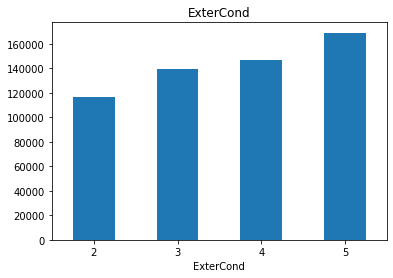

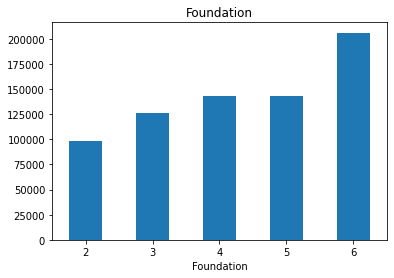

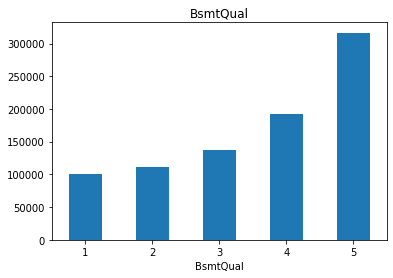

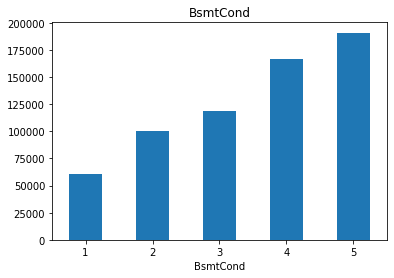

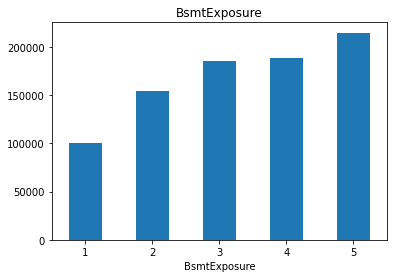

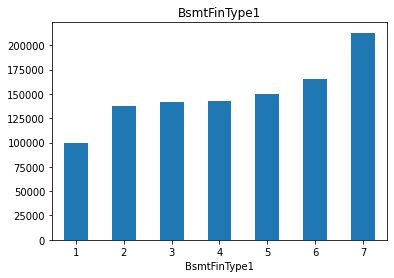

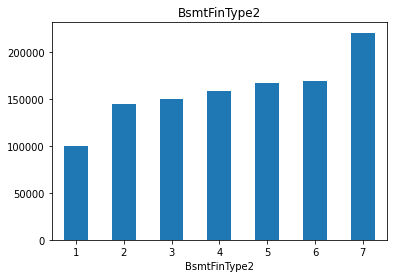

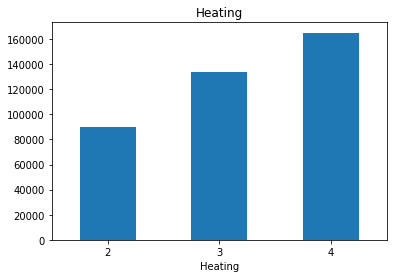

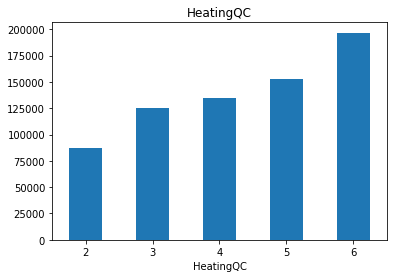

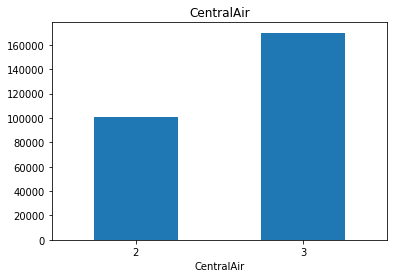

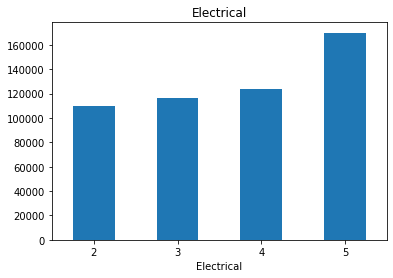

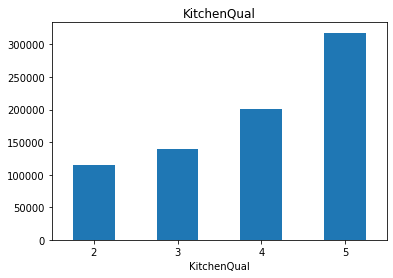

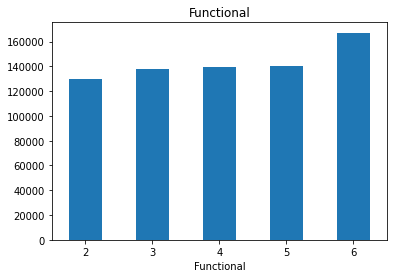

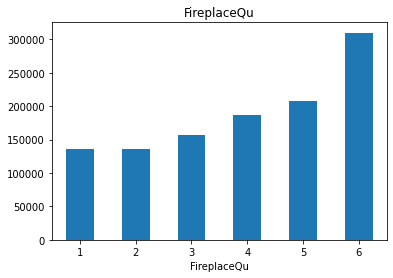

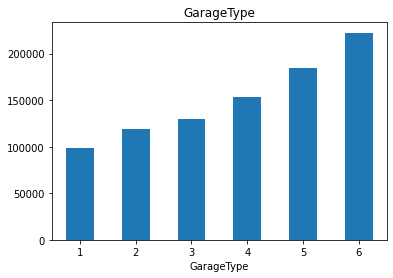

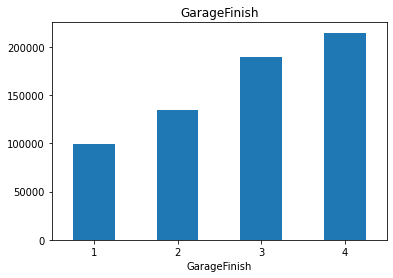

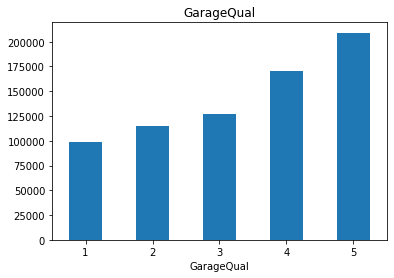

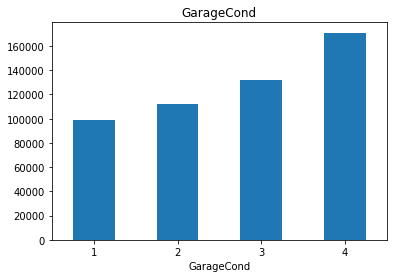

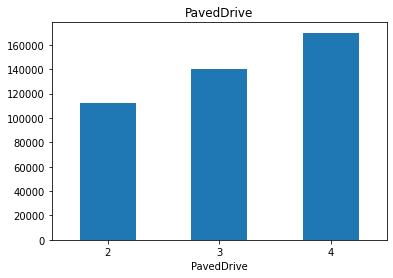

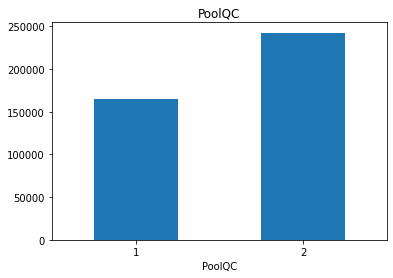

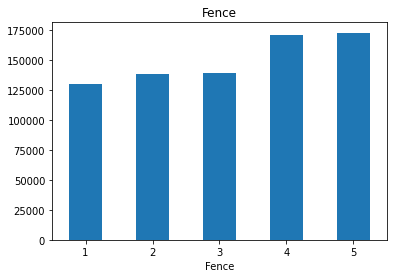

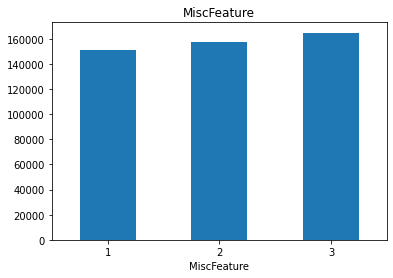

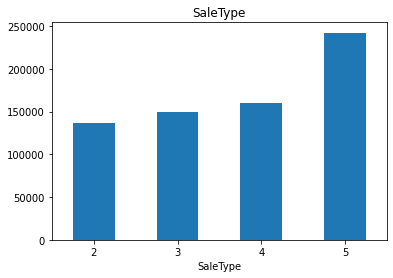

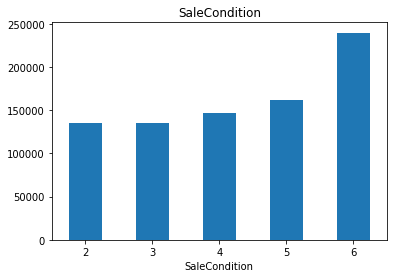

In [445]:
temp = x_train_prep.copy()
temp['SalePrice'] = y_train

for var in cat_vars:
    analyze_discrete_vars(temp, var)

In [446]:
train_vars = [var for var in x_train_prep.columns if var not in ['Id', 'SalePrice']]

## Features scaling

In [477]:
scaler = MinMaxScaler()
x_train_fullprep = x_train_prep[train_vars].copy()
x_valid_fullprep = x_valid_prep[train_vars].copy()

x_train_fullprep[train_vars] = scaler.fit_transform(x_train_fullprep[train_vars])
x_valid_fullprep[train_vars] = scaler.transform(x_valid_fullprep[train_vars])

In [448]:
x_train_fullprep.isnull().any().any()

False

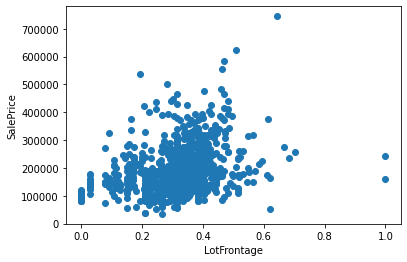

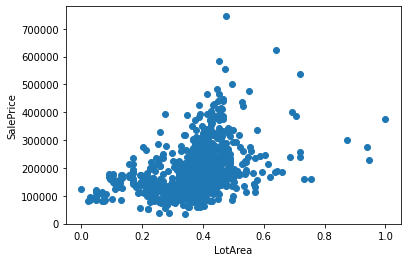

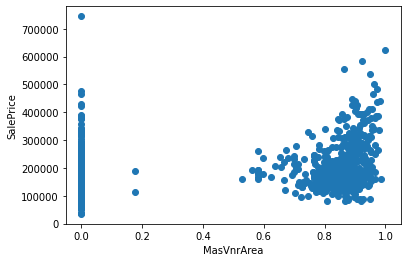

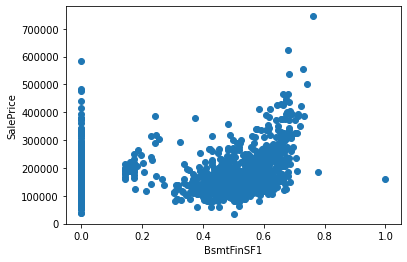

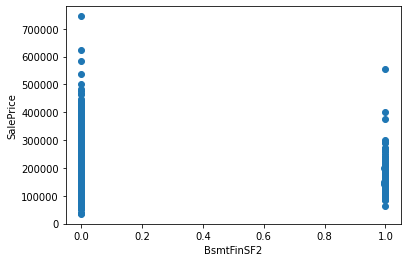

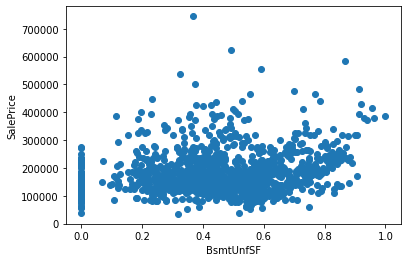

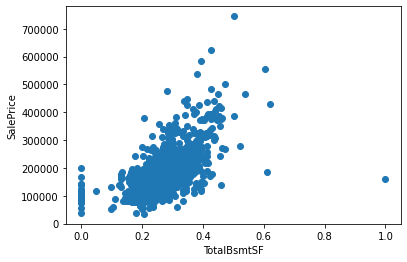

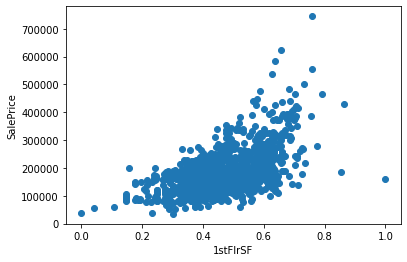

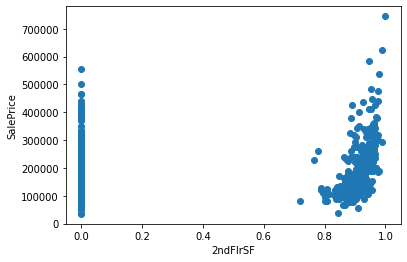

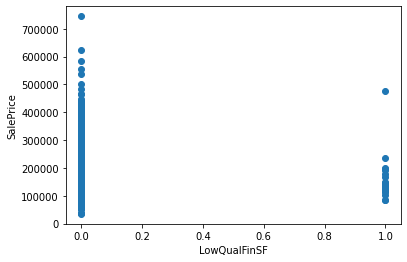

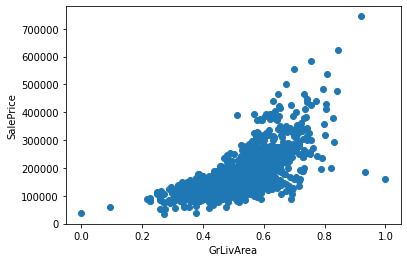

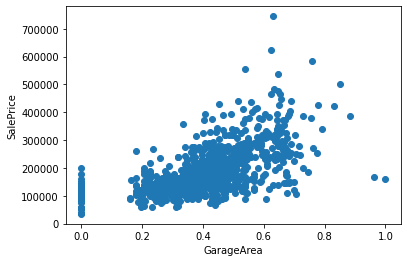

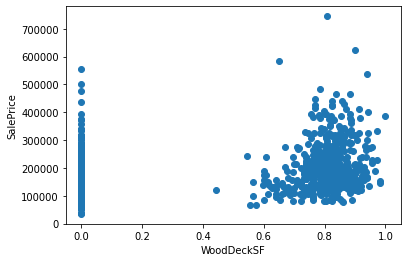

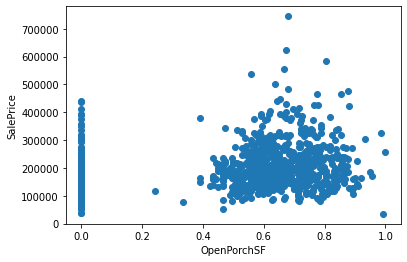

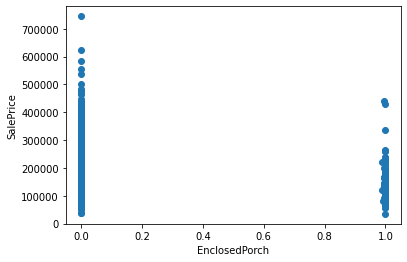

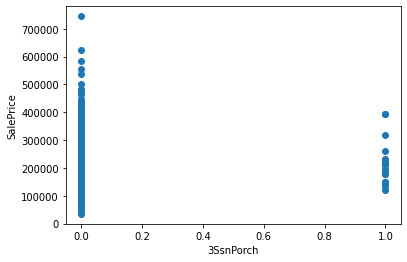

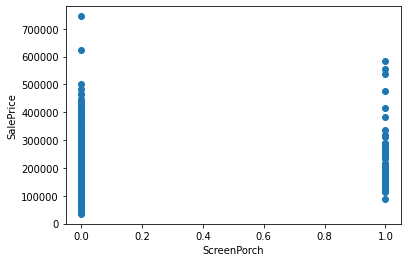

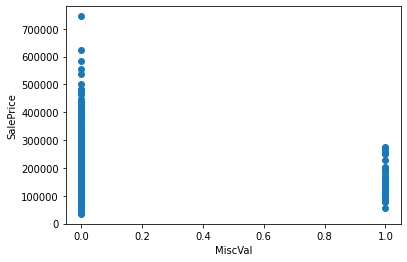

In [449]:
temp = x_train_fullprep.copy()
temp['SalePrice']=y_train
for var in cont_vars:
    analyze_continuous_var(temp, var)

In [450]:
# export to csv
x_train_fullprep.to_csv(root/'xtrain.csv')
x_valid_fullprep.to_csv(root/'xvalid.csv')

# Feature selection

In [451]:
from scipy.stats import uniform, randint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel

np.random.seed(42)
ls_params = {'alpha':uniform(0.0001, 1)}
rs_params = {'n_estimators': randint(2, 100), 'max_depth': randint(2,20), 'max_leaf_nodes': randint(2, 20)}

In [452]:
ls = Lasso()
rs = RandomForestRegressor()

ls_cv = RandomizedSearchCV(ls, ls_params, n_iter=100)
rs_cv = RandomizedSearchCV(rs, rs_params, n_iter=50)

In [453]:
ls_cv.fit(x_train_fullprep, y_train)

/Users/boonchuay/Documents 2/deployment-of-ml-model/deploy-ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6787422636.141602, tolerance: 613709200.1144117
  positive)


RandomizedSearchCV(estimator=Lasso(), n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcff42b66d0>})

In [454]:
ls_cv.best_estimator_

Lasso(alpha=0.9869869366005173)

In [455]:
ls_cv.best_score_

0.7939526776773359

In [456]:
print(f'R^2 : {ls_cv.score(x_valid_fullprep, y_valid)}')
print(f'mse : {mean_absolute_error(y_valid, ls_cv.best_estimator_.predict(x_valid_fullprep))}')

R^2 : 0.8035059561474608
mse : 23397.830665552014


In [457]:
rs_cv.fit(x_train_fullprep, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcff6d00e10>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcff6d0e910>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcff6d0f950>})

In [458]:
rs_cv.best_estimator_

RandomForestRegressor(max_depth=5, max_leaf_nodes=19, n_estimators=76)

In [459]:
print(f'R^2 : {rs_cv.score(x_valid_fullprep, y_valid)}')
print(f'mse : {mean_squared_error(y_valid, rs_cv.best_estimator_.predict(x_valid_fullprep))**0.5}')

R^2 : 0.8563088244510547
mse : 34155.03479030044


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,  3.,  2.,  6.,
        13.,  8.,  9., 12., 29., 44., 26., 19.,  6., 11.,  4.,  3.,  2.,
         2.,  2.,  1.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-115109.46155359, -108975.71195111, -102841.96234864,
         -96708.21274616,  -90574.46314368,  -84440.7135412 ,
         -78306.96393872,  -72173.21433624,  -66039.46473376,
         -59905.71513128,  -53771.9655288 ,  -47638.21592632,
         -41504.46632384,  -35370.71672136,  -29236.96711888,
         -23103.2175164 ,  -16969.46791392,  -10835.71831144,
          -4701.96870896,    1431.78089352,    7565.530496  ,
          13699.28009848,   19833.02970096,   25966.77930344,
          32100.52890592,   38234.2785084 ,   44368.02811088,
          50501.77771336,   56635.52731583,   62769.27691831,
          68903.02652079,   75036.77612327,   81170.52572575,
          87304.27532823,   93438.

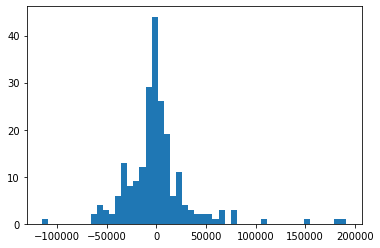

In [460]:
err = y_valid - rs_cv.best_estimator_.predict(x_valid_fullprep)
plt.hist(err, bins=50)

In [461]:
rs_cv.best_estimator_

RandomForestRegressor(max_depth=5, max_leaf_nodes=19, n_estimators=76)

In [462]:
feature_importances = rs_cv.best_estimator_.feature_importances_
features = x_train_fullprep.columns

selected_feat = list(zip(features, feature_importances))
selected_feat = sorted(selected_feat, key=lambda x: x[1], reverse=True)

In [463]:
selected_feat = list(filter(lambda x: x[1] > 1e-3, selected_feat))

pd.DataFrame(selected_feat, columns=['features','feature_importances']).to_csv(root/'selected_features.csv')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

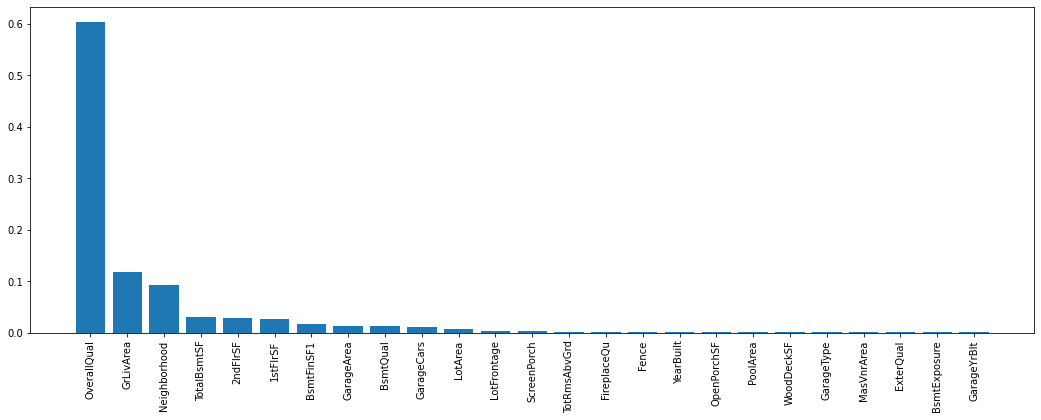

In [464]:
sel_features = list(map(lambda x : x[0], selected_feat))
feature_importances = list(map(lambda x : x[1], selected_feat))

plt.figure(figsize=(18,6))
plt.bar(sel_features, feature_importances)
plt.xticks(rotation='vertical')

# Model building

In [465]:
rs_cv.best_estimator_.fit(x_train_fullprep[sel_features], y_train)

RandomForestRegressor(max_depth=5, max_leaf_nodes=19, n_estimators=76)

In [466]:
rs_cv.best_estimator_.score(x_valid_fullprep[sel_features], y_valid)

0.861970854820885

In [467]:
print(f'R^2 : {rs_cv.score(x_valid_fullprep[sel_features], y_valid)}')
print(f'mse : {mean_squared_error(y_valid, rs_cv.best_estimator_.predict(x_valid_fullprep[sel_features]))**0.5}')

R^2 : 0.861970854820885
mse : 33475.34659972378


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  2.,  4.,  5.,  9.,  9.,
         7., 11., 21., 46., 25., 26., 11.,  6., 11.,  4.,  0.,  1.,  3.,
         1.,  2.,  3.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-103307.58792685,  -97276.4357658 ,  -91245.28360474,
         -85214.13144369,  -79182.97928263,  -73151.82712158,
         -67120.67496052,  -61089.52279947,  -55058.37063841,
         -49027.21847736,  -42996.0663163 ,  -36964.91415525,
         -30933.76199419,  -24902.60983314,  -18871.45767208,
         -12840.30551103,   -6809.15334997,    -778.00118892,
           5253.15097214,   11284.30313319,   17315.45529425,
          23346.6074553 ,   29377.75961636,   35408.91177741,
          41440.06393847,   47471.21609952,   53502.36826058,
          59533.52042163,   65564.67258269,   71595.82474374,
          77626.9769048 ,   83658.12906585,   89689.28122691,
          95720.43338796,  101751.

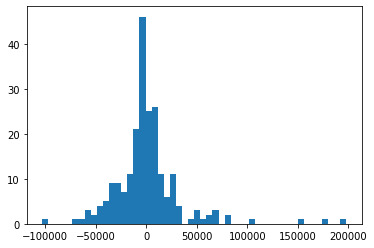

In [468]:
err = y_valid - rs_cv.best_estimator_.predict(x_valid_fullprep[sel_features])
plt.hist(err, bins=50)

# forecasting on test set

In [469]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [470]:
test_df_filled, _, _ = fill_missing_values(test_df)

In [471]:
test_df_elapsed = add_elapsedyear(test_df_filled, 'YearRemodAdd')

In [472]:
test_df_tf = test_df_elapsed.copy()

test_df_tf[cont_vars] = tf.transform(test_df_tf[cont_vars])

In [473]:
test_df_rmrare = remove_rare_label(test_df_tf, rare_labels=rare_label_dic)

In [474]:
test_df_labeled = test_df_rmrare.copy()

for var in cat_vars:
    test_df_labeled[var] = label_encoding_w_order(test_df_labeled, var, word_index_dic=word_index_dic)

In [478]:
test_df_fullprep = test_df_labeled[train_vars].copy()
test_df_fullprep[train_vars] = scaler.transform(test_df_fullprep[train_vars])

In [482]:
y_test_pred = rs_cv.best_estimator_.predict(test_df_fullprep[sel_features])

In [494]:
submissions = pd.DataFrame(np.c_[test_df['Id'], y_test_pred], columns=['Id', 'SalePrice'])
submissions['Id'] = submissions['Id'].astype('int32')

In [496]:
submissions.to_csv(root/'test_submissions.csv', index=False)

In [495]:
submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int32  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 17.2 KB
